# Satelia® Cardio cohort data analysis

#### Author: Dègninou Yehadji (MPH, MSc, MBA)
#### Contact: degninou.yehadji@fulbrightmail.org
#### Date: July 19, 2023
#### Contractor: Acacia Tools
#### Project: Satelia® 5 and 10
#### Version: 2.0

This notebook contains an analysis of Satelia® Cardio cohort data, focusing on descriptive statistics and survival analysis. The analysis includes data cleaning, exploratory data analysis, statistical modeling, and result interpretation.

## Table of Contents
1. [Load required packages](#Load-required-packages)
2. [Read and merge the datasets](#Read-and-merge-the-datasets)
3. [Determine earliest date of enrollment](#Determine-earliest-date-of-enrollement)
4. [Frequency by age group](#Frequency-by-age-group)
5. [Frequency by Literacy](#Frequency-by-Litteracy)
6. [Descriptive stat of continuous variables](#Descriptive-stat-of-continuous-variables)
   - [For entire cohort](#For-entire-cohort)
   - [By age group](#By-age-group)
   - [Literacy](#Litteracy)
7. [Co-factors by age group](#Co-factors-by-age-group)
8. [Co-factors and etiology](#Co-factors-and-ethiology)
   - [By age group](#By-age-group-1)
   - [By literacy](#By-litteracy)
9. [Hospitalization morbidities](#Hospitalization-morbidities)
   - [By age group](#By-age-group-2)
   - [By literacy](#By-litteracy-1)
10. [HF Hospitalisation co-morbidities](#HF-Hospitalisation-co-morbidities)
    - [By age groups](#By-age-groups)
    - [By Literacy](#By-Literacy)
11. [Cumulative hazard of death](#Cumulative-hazard-of-death)
    - [Cumulative hazard of death - Total](#Cumulative-hazard-of-death---Total)
    - [Cumulative hazard of death - by age group](#Cumulative-hazard-of-death---by-age-group)
    - [Cumulative hazard of death - by Literacy](#Cumulative-hazard-of-death---by-Litteracy)
12. [Cumulative hazard of hospitalization](#Cumulative-hazard-of-hospitalization)
    - [Cumulative hazard of hospitalization - Total](#Cumulative-hazard-of-hospitalization---Total)
    - [Cumulative hazard of hospitalization - By age group](#Cumulative-hazard-of-hospitalization---By-age-group)
    - [Cumulative hazard of hospitalization - By literacy](#Cumulative-hazard-of-hospitalization---By-litteracy)
    - [Cumulative hazard of HF hospitalization - by Literacy](#Cumulative-hazard-of-HF-hospitalization---by-Litteracy)
13. [Cox regression for death](#Cox-regression-for-death)
    - [Contingency tables for factors by 'DECES'](#Contingency-tables-for-factors-by-DECES)
    - [Cox regression for each factor and death](#Cox-regression-for-each-factor-and-death)
14. [Cox regression for each factor and IC](#Cox-regression-for-each-factor-and-IC)
    - [Contingency tables for factors by IC](#Contingency-tables-for-factors-by-IC)
    - [Cox regression for each factor and death](#Cox-regression-for-each-factor-and-death-1)
    - [Cox regression for all associated factors and IC](#Cox-regression-for-all-associated-factors-and-IC)
15. [KM Survival analysis](#KM-Survival-analysis)
    - [KM for death by age group](#KM-for-death-by-age-group)
    - [KM for death by Literacy](#KM-for-death-by-Litteracy)
    - [KM for HF by Age](#KM-for-HF-by-Age)
    - [KM for HF by Lit](#KM-for-HF-by-Litt)
    - [Logranktest for Mortality and HF by Age](#Logranktest-for-Mortality-and-HF-by-Age)
    - [Logranktest for Mortality and HF by Litt](#Logranktest-for-Mortality-and-HF-by-Litt)

# Load required packages 

In [1]:
# Import required packages 

import os
import json
import warnings

import datetime
from datetime import timedelta
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

import missingno as msno 

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
import xlrd

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

# Read and merge the datasets

In [2]:
# Set working directory
os.chdir ('../../../Acacia Tools/Satelia 05 10/data')

# H:\My Drive\Acacia Tools\Satelia N\data '../../Acacia Tools/Satelia 05 10/data'

In [3]:
# Read data
patient = pd.read_excel('patients.xlsx', sheet_name = 'patients')
hospit = pd.read_excel('hospitalizations.xlsx', sheet_name = 'hospit')

In [4]:
# Merge 'patient' and 'hospit' on 'ID_PAT'
pathospit0 = pd.merge(patient, hospit, on='ID_PAT', how='outer')
pathospit0.to_excel('pathospit.xlsx', index=False)

In [5]:
# Read the saved, quality cheched and preprocessed pathospit dataset
pathospit = pd.read_excel('pathospit2.xlsx', sheet_name = 'Sheet1')

# Determine earlierst date of enrollement 

In [6]:
# Convert the SUIVI_DEBUT column to datetime if it's not already
pathospit_date = pathospit.copy()
pathospit_date['SUIVI_DEBUT'] = pd.to_datetime(pathospit_date['SUIVI_DEBUT'])

# Find the earliest date
earliest_date = pathospit_date['SUIVI_DEBUT'].min()

# Find the latest date
latest_date = pathospit_date['SUIVI_DEBUT'].max()

print("Earliest date:", earliest_date)
print("Latest date:", latest_date)

Earliest date: 2018-08-28 00:00:00
Latest date: 2023-06-27 00:00:00


# Frequency by age group

In [7]:
# List of variables for which to create contingency tables and perform Chi-square tests
variables = ['SEXE', 'DAI_x', 'LITERATIEX', 'SUIVI_FREQ', 'INCOHORT', 'SUIVI_FIN_MOTIF', 'NYHA', 'MOTIF', 'IC', 'TYPE']

# Loop through the list of variables and perform the operations
for var in variables:
    # Create contingency table
    contingency_table = pd.crosstab(pathospit[var], pathospit['AGEG'])
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results
    print(f'Contingency table for {var}:\n')
    print(contingency_table)
    print(f'\nChi-square test results for {var} by AGEG:\n')
    print(f'Chi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}\n')
    print('------------------------------------------------------------------------------------\n')

Contingency table for SEXE:

AGEG     1     2    3
SEXE                 
F     2081  1494  600
M     5244  2129  524

Chi-square test results for SEXE by AGEG:

Chi-square statistic: 369.84867090709383
P-value: 4.87956989139126e-81
Degrees of freedom: 2

------------------------------------------------------------------------------------

Contingency table for DAI_x:

AGEG                          1     2    3
DAI_x                                     
Biotronik Home Monitoring   281    68   13
Boston Scientific           296    56   11
Medtronic Carelink          392   102    8
Merlin Saint Jude           269    75   12
Non equipe                 2606  1442  484
Sorin Smartview             139    41    6

Chi-square test results for DAI_x by AGEG:

Chi-square statistic: 251.62850542577434
P-value: 2.4671130301856073e-48
Degrees of freedom: 10

------------------------------------------------------------------------------------

Contingency table for LITERATIEX:

AGEG           1     2

# Frequency by Litteracy

In [8]:
# List of variables for which to create contingency tables and perform Chi-square tests
variables = ['SEXE', 'DAI_x', 'AGEG', 'SUIVI_FREQ', 'INCOHORT', 'SUIVI_FIN_MOTIF', 'NYHA', 'MOTIF', 'IC', 'TYPE']

# Loop through the list of variables and perform the operations
for var in variables:
    # Create contingency table
    contingency_table = pd.crosstab(pathospit[var], pathospit['LITERATIEX'])
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results
    print(f'Contingency table for {var}:\n')
    print(contingency_table)
    print(f'\nChi-square test results for {var} by LITERATIEX:\n')
    print(f'Chi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}\n')
    print('------------------------------------------------------------------------------------\n')

Contingency table for SEXE:

LITERATIEX     0     1
SEXE                  
F           2096  2079
M           3135  4762

Chi-square test results for SEXE by LITERATIEX:

Chi-square statistic: 122.31180245859304
P-value: 1.9726704081589225e-28
Degrees of freedom: 1

------------------------------------------------------------------------------------

Contingency table for DAI_x:

LITERATIEX                    0     1
DAI_x                                
Biotronik Home Monitoring   115   247
Boston Scientific           117   246
Medtronic Carelink          181   321
Merlin Saint Jude           129   227
Non equipe                 1990  2542
Sorin Smartview              66   120

Chi-square test results for DAI_x by LITERATIEX:

Chi-square statistic: 50.68426154819083
P-value: 1.0037474171976379e-09
Degrees of freedom: 5

------------------------------------------------------------------------------------

Contingency table for AGEG:

LITERATIEX     0     1
AGEG                  
1     

# Descriptive stat of continuous variables

## For entire cohort

In [9]:
# List of continuous variables to compute descriptive statistics for
variables = ['DUREE_SUIVI', 'DUREE_AV_HOSPIX', 'DUREE_HOSPI', 'FEVG', 'NTPROBNP', 'BNP']

# Compute descriptive statistics for the specified columns
descriptive_stats = pathospit[variables].describe()

# Print the result
print(descriptive_stats)

        DUREE_SUIVI  DUREE_AV_HOSPIX  DUREE_HOSPI         FEVG      NTPROBNP  \
count  12072.000000      5868.000000  5868.000000  9604.000000   5429.000000   
mean      15.143307         5.252386     7.259373    41.173084   4165.233376   
std       12.069333         6.744594     7.247332    13.979634   5997.933257   
min        1.000000         0.000000     0.000000     5.000000      0.000000   
25%        5.000000         1.000000     2.000000    30.000000   1069.000000   
50%       12.000000         2.000000     6.000000    40.000000   2254.000000   
75%       23.000000         7.000000    10.000000    50.000000   4714.000000   
max       58.000000        49.000000    30.000000    93.000000  80000.000000   

                BNP  
count   1915.000000  
mean     915.475196  
std     1887.501132  
min        0.000000  
25%      199.500000  
50%      420.000000  
75%      926.000000  
max    30000.000000  


In [10]:
# Compute descriptive statistics for the specified columns
descriptive_stats = pathospit['AGE'].describe()

# Print the result
print(descriptive_stats)

count    12072.000000
mean        74.222250
std         13.085182
min         19.000000
25%         67.000000
50%         76.000000
75%         84.000000
max        103.000000
Name: AGE, dtype: float64


## By age group

In [11]:
# List of variables for which to perform ANOVA and present summary statistics
variables = ['DUREE_SUIVI', 'DUREE_AV_HOSPI', 'DUREE_HOSPI']

# Loop through the list of variables and perform the operations
for var in variables:
    if var == 'DUREE_AV_HOSPI':
        # Only consider rows where ID_HOSPIT is not empty (or null)
        data = pathospit[pathospit['ID_HOSPIT'].notnull()]
    else:
        data = pathospit
    
    # Generate summary statistics by 'AGEG'
    print(f'Summary statistics for {var} by AGEG:\n')
    print(data.groupby('AGEG')[var].describe())
    print('------------------------------------------------------------------------------------\n')

    # Perform ANOVA
    model = ols(f'{var} ~ C(AGEG)', data=data).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)

    # Print the results
    print(f'ANOVA results for {var} by AGEG:\n')
    print(aov_table)
    print('------------------------------------------------------------------------------------\n')


Summary statistics for DUREE_SUIVI by AGEG:

       count       mean        std  min  25%   50%   75%   max
AGEG                                                          
1     7325.0  15.516177  12.145865  1.0  6.0  12.0  24.0  58.0
2     3623.0  14.494894  11.842371  1.0  5.0  11.0  22.0  56.0
3     1124.0  14.803381  12.205189  1.0  5.0  12.0  23.0  55.0
------------------------------------------------------------------------------------

ANOVA results for DUREE_SUIVI by AGEG:

                sum_sq       df         F    PR(>F)
C(AGEG)   2.671544e+03      2.0  9.182355  0.000104
Residual  1.755697e+06  12069.0       NaN       NaN
------------------------------------------------------------------------------------

Summary statistics for DUREE_AV_HOSPI by AGEG:

       count      mean       std  min  25%  50%  75%   max
AGEG                                                      
1     3288.0  4.848540  6.368431  0.0  1.0  2.0  6.0  49.0
2     1953.0  5.552483  7.038131  0.0  1.0  3.0

In [12]:
# List of variables for which to perform ANOVA and present summary statistics
variables = ['FEVG', 'NTPROBNP', 'BNP']

# Loop through the list of variables and perform the operations
for var in variables:
    data = pathospit
    
    # Generate summary statistics by 'AGEG'
    print(f'Summary statistics for {var} by AGEG:\n')
    print(data.groupby('AGEG')[var].describe())
    print('------------------------------------------------------------------------------------\n')

    # Perform ANOVA
    model = ols(f'{var} ~ C(AGEG)', data=data).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)

    # Print the results
    print(f'ANOVA results for {var} by AGEG:\n')
    print(aov_table)
    print('------------------------------------------------------------------------------------\n')

Summary statistics for FEVG by AGEG:

       count       mean        std   min   25%   50%   75%   max
AGEG                                                            
1     5894.0  38.050526  13.389902   7.0  29.0  35.0  46.0  90.0
2     2850.0  45.537053  13.563088   5.0  35.0  45.0  55.0  93.0
3      860.0  48.111512  12.898905  14.9  40.0  50.0  60.0  80.0
------------------------------------------------------------------------------------

ANOVA results for FEVG by AGEG:

                sum_sq      df           F         PR(>F)
C(AGEG)   1.531466e+05     2.0  426.545344  3.361291e-178
Residual  1.723569e+06  9601.0         NaN            NaN
------------------------------------------------------------------------------------

Summary statistics for NTPROBNP by AGEG:

       count         mean          std    min      25%     50%      75%  \
AGEG                                                                      
1     3204.0  3555.170412  5350.637148    0.0   836.00  1856.5  40

## Litteracy

In [13]:
# List of variables for which to perform ANOVA and present summary statistics
variables = ['AGE', 'DUREE_SUIVI', 'DUREE_AV_HOSPI', 'DUREE_HOSPI']

# Loop through the list of variables and perform the operations
for var in variables:
    if var == 'DUREE_AV_HOSPI':
        # Only consider rows where ID_HOSPIT is not empty (or null)
        data = pathospit[pathospit['ID_HOSPIT'].notnull()]
    else:
        data = pathospit
    
    # Generate summary statistics by 'AGEG'
    print(f'Summary statistics for {var} by LITERATIEX:\n')
    print(data.groupby('LITERATIEX')[var].describe())
    print('------------------------------------------------------------------------------------\n')

    # Perform ANOVA
    model = ols(f'{var} ~ C(LITERATIEX)', data=data).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)

    # Print the results
    print(f'ANOVA results for {var} by LITERATIEX:\n')
    print(aov_table)
    print('------------------------------------------------------------------------------------\n')

Summary statistics for AGE by LITERATIEX:

             count       mean        std   min   25%   50%   75%    max
LITERATIEX                                                             
0           5231.0  79.432231  10.233131  19.0  74.0  81.0  87.0  102.0
1           6841.0  70.238415  13.618594  19.0  62.0  72.0  80.0  103.0
------------------------------------------------------------------------------------

ANOVA results for AGE by LITERATIEX:

                     sum_sq       df            F  PR(>F)
C(LITERATIEX)  2.505628e+05      1.0  1665.123355     0.0
Residual       1.816258e+06  12070.0          NaN     NaN
------------------------------------------------------------------------------------

Summary statistics for DUREE_SUIVI by LITERATIEX:

             count       mean        std  min  25%   50%   75%   max
LITERATIEX                                                          
0           5231.0  14.262283  11.387073  1.0  5.0  11.0  21.0  56.0
1           6841.0  15.8169

In [14]:
# List of variables for which to perform ANOVA and present summary statistics
variables = ['FEVG', 'NTPROBNP', 'BNP']

# Loop through the list of variables and perform the operations
for var in variables:
    data = pathospit
    
    # Generate summary statistics by 'LITERATIEX'
    print(f'Summary statistics for {var} by LITERATIEX:\n')
    print(data.groupby('LITERATIEX')[var].describe())
    print('------------------------------------------------------------------------------------\n')

    # Perform ANOVA
    model = ols(f'{var} ~ C(LITERATIEX)', data=data).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)

    # Print the results
    print(f'ANOVA results for {var} by LITERATIEX:\n')
    print(aov_table)
    print('------------------------------------------------------------------------------------\n')

Summary statistics for FEVG by LITERATIEX:

             count       mean        std  min   25%   50%   75%   max
LITERATIEX                                                           
0           4171.0  43.218940  14.090116  5.0  30.0  44.0  55.0  93.0
1           5433.0  39.602448  13.689565  7.0  30.0  39.0  50.0  90.0
------------------------------------------------------------------------------------

ANOVA results for FEVG by LITERATIEX:

                     sum_sq      df           F        PR(>F)
C(LITERATIEX)  3.086049e+04     1.0  160.533941  1.693465e-36
Residual       1.845855e+06  9602.0         NaN           NaN
------------------------------------------------------------------------------------

Summary statistics for NTPROBNP by LITERATIEX:

             count         mean          std  min     25%     50%     75%  \
LITERATIEX                                                                  
0           2383.0  4782.485942  6627.034843  0.0  1316.0  2600.0  5548.0   


# Co-factors and ethiology 

## By age group

In [15]:
# List of variables for which to create contingency tables and perform Chi-square tests
variables = ['HTA_x', 'DYSLIPIDEMIE', 'OBESITE', 'HEREDITE', 'TABAC', 'PREDIABETE', 'INACTIF_SEDENTAIRE', 
             'ACFA', 'DEPRESSION', 'INSUFFISANCE_RENALE', 'DIABETE', 'IDM', 'SAOS', 'BPCO', 'AVC', 'CANCER']

# Loop through the list of variables and perform the operations
for var in variables:
    # Create contingency table
    contingency_table = pd.crosstab(pathospit[var], pathospit['AGEG'])
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results
    print(f'Contingency table for {var}:\n')
    print(contingency_table)
    print(f'\nChi-square test results for {var} by AGEG:\n')
    print(f'Chi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}\n')
    print('------------------------------------------------------------------------------------\n')

Contingency table for HTA_x:

AGEG      1     2    3
HTA_x                 
0.0    3686  1463  445
1.0    3302  2035  643

Chi-square test results for HTA_x by AGEG:

Chi-square statistic: 137.94909491524606
P-value: 1.1084973197878124e-30
Degrees of freedom: 2

------------------------------------------------------------------------------------

Contingency table for DYSLIPIDEMIE:

AGEG             1     2    3
DYSLIPIDEMIE                 
0.0           4346  2116  779
1.0           2642  1382  309

Chi-square test results for DYSLIPIDEMIE by AGEG:

Chi-square statistic: 44.74764317342324
P-value: 1.9194320658169268e-10
Degrees of freedom: 2

------------------------------------------------------------------------------------

Contingency table for OBESITE:

AGEG        1     2    3
OBESITE                 
0.0      4616  2836  978
1.0      2372   662  110

Chi-square test results for OBESITE by AGEG:

Chi-square statistic: 442.2885908828074
P-value: 9.083490899446324e-97
Degrees of 

## By litteracy

In [16]:
# List of variables for which to create contingency tables and perform Chi-square tests
variables = ['HTA_x', 'DYSLIPIDEMIE', 'OBESITE', 'HEREDITE', 'TABAC', 'PREDIABETE', 'INACTIF_SEDENTAIRE', 
             'ACFA', 'DEPRESSION', 'INSUFFISANCE_RENALE', 'DIABETE', 'IDM', 'SAOS', 'BPCO', 'AVC', 'CANCER']

# Loop through the list of variables and perform the operations
for var in variables:
    # Create contingency table
    contingency_table = pd.crosstab(pathospit[var], pathospit['LITERATIEX'])
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results
    print(f'Contingency table for {var}:\n')
    print(contingency_table)
    print(f'\nChi-square test results for {var} by LITERATIEX:\n')
    print(f'Chi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}\n')
    print('------------------------------------------------------------------------------------\n')

Contingency table for HTA_x:

LITERATIEX     0     1
HTA_x                 
0.0         2218  3376
1.0         2828  3152

Chi-square test results for HTA_x by LITERATIEX:

Chi-square statistic: 68.32045379713989
P-value: 1.3897199286229157e-16
Degrees of freedom: 1

------------------------------------------------------------------------------------

Contingency table for DYSLIPIDEMIE:

LITERATIEX       0     1
DYSLIPIDEMIE            
0.0           3146  4095
1.0           1900  2433

Chi-square test results for DYSLIPIDEMIE by LITERATIEX:

Chi-square statistic: 0.16259489339639066
P-value: 0.6867786119682338
Degrees of freedom: 1

------------------------------------------------------------------------------------

Contingency table for OBESITE:

LITERATIEX     0     1
OBESITE               
0.0         3846  4584
1.0         1200  1944

Chi-square test results for OBESITE by LITERATIEX:

Chi-square statistic: 51.451108964796035
P-value: 7.340250729632735e-13
Degrees of freedom: 1



# Hospitalization morbidities

## By age group

In [17]:
# Filter out rows where 'ID_HOSPIT' is empty
pathospit_clean = pathospit[pathospit['ID_HOSPIT'].notnull()]

# Variables to create contingency tables and perform Chi-square tests
variables = ['CHIRURGIE_CARDIAQUE', 'RYTHME', 'DAI_y', 'ISCHEMIE_MYOCARDIQUE', 'PACEMAKER', 'HTA_y', 
             'ANEMIE', 'ACR', 'CORONAROGRAPHIE', 'TRAITEMENT', 'ALIMENTATION']

# Replace empty cells with 0 in the selected columns
pathospit_clean = pathospit_clean.fillna({var: 0 for var in variables})

# Loop through the variables
for var in variables:
    # Create the contingency table
    contingency_table = pd.crosstab(pathospit_clean[var], pathospit_clean['AGEG'])
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print results
    print(f'Contingency table for {var}:\n')
    print(contingency_table)
    print(f'\nChi-square test results for {var} by AGEG:\n')
    print(f'Chi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}\n')
    print('------------------------------------------------------------------------------------\n')

Contingency table for CHIRURGIE_CARDIAQUE:

AGEG                    1     2    3
CHIRURGIE_CARDIAQUE                 
0.0                  3262  1946  625
1.0                    26     7    2

Chi-square test results for CHIRURGIE_CARDIAQUE by AGEG:

Chi-square statistic: 4.774166323492157
P-value: 0.0918973430140687
Degrees of freedom: 2

------------------------------------------------------------------------------------

Contingency table for RYTHME:

AGEG       1     2    3
RYTHME                 
0.0     3229  1924  619
1.0       59    29    8

Chi-square test results for RYTHME by AGEG:

Chi-square statistic: 1.2949740979528646
P-value: 0.523359301951078
Degrees of freedom: 2

------------------------------------------------------------------------------------

Contingency table for DAI_y:

AGEG      1     2    3
DAI_y                 
0.0    3247  1949  627
1.0      41     4    0

Chi-square test results for DAI_y by AGEG:

Chi-square statistic: 22.911402706203432
P-value: 1.058

## By litteracy

In [18]:
# Filter out rows where 'ID_HOSPIT' is empty
pathospit_clean = pathospit[pathospit['ID_HOSPIT'].notnull()]

# Variables to create contingency tables and perform Chi-square tests
variables = ['CHIRURGIE_CARDIAQUE', 'RYTHME', 'DAI_y', 'ISCHEMIE_MYOCARDIQUE', 'PACEMAKER', 'HTA_y', 
             'ANEMIE', 'ACR', 'CORONAROGRAPHIE', 'TRAITEMENT', 'ALIMENTATION']

# Replace empty cells with 0 in the selected columns
pathospit_clean = pathospit_clean.fillna({var: 0 for var in variables})

# Loop through the variables
for var in variables:
    # Create the contingency table
    contingency_table = pd.crosstab(pathospit_clean[var], pathospit_clean['LITERATIEX'])
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print results
    print(f'Contingency table for {var}:\n')
    print(contingency_table)
    print(f'\nChi-square test results for {var} by LITERATIEX:\n')
    print(f'Chi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}\n')
    print('------------------------------------------------------------------------------------\n')

Contingency table for CHIRURGIE_CARDIAQUE:

LITERATIEX              0     1
CHIRURGIE_CARDIAQUE            
0.0                  3120  2713
1.0                    13    22

Chi-square test results for CHIRURGIE_CARDIAQUE by LITERATIEX:

Chi-square statistic: 3.107535133529631
P-value: 0.07793081573748523
Degrees of freedom: 1

------------------------------------------------------------------------------------

Contingency table for RYTHME:

LITERATIEX     0     1
RYTHME                
0.0         3084  2688
1.0           49    47

Chi-square test results for RYTHME by LITERATIEX:

Chi-square statistic: 0.13116498540105906
P-value: 0.7172271871293763
Degrees of freedom: 1

------------------------------------------------------------------------------------

Contingency table for DAI_y:

LITERATIEX     0     1
DAI_y                 
0.0         3113  2710
1.0           20    25

Chi-square test results for DAI_y by LITERATIEX:

Chi-square statistic: 1.1188607454409207
P-value: 0.290163

# HF Hospitalisation co-morbidities

## By age groups

In [19]:
# Filter out rows where 'ICX' is 1 (HF Hospitalisation)
pathospit_clean = pathospit[pathospit['ICX'] == 1]

# Variables to create contingency tables and perform Chi-square tests
variables = ['CHIRURGIE_CARDIAQUE', 'RYTHME', 'DAI_y', 'ISCHEMIE_MYOCARDIQUE', 'PACEMAKER', 'HTA_y', 
             'ANEMIE', 'ACR', 'CORONAROGRAPHIE', 'TRAITEMENT', 'ALIMENTATION']

# Replace empty cells with 0 in the selected columns
pathospit_clean = pathospit_clean.fillna({var: 0 for var in variables})

# Loop through the variables
for var in variables:
    # Create the contingency table
    contingency_table = pd.crosstab(pathospit_clean[var], pathospit_clean['AGEG'])
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print results
    print(f'Contingency table for {var}:\n')
    print(contingency_table)
    print(f'\nChi-square test results for {var} by AGEG:\n')
    print(f'Chi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}\n')
    print('------------------------------------------------------------------------------------\n')

Contingency table for CHIRURGIE_CARDIAQUE:

AGEG                    1     2    3
CHIRURGIE_CARDIAQUE                 
0.0                  2075  1098  336
1.0                    26     7    2

Chi-square test results for CHIRURGIE_CARDIAQUE by AGEG:

Chi-square statistic: 3.3006845304844306
P-value: 0.19198418785987026
Degrees of freedom: 2

------------------------------------------------------------------------------------

Contingency table for RYTHME:

AGEG       1     2    3
RYTHME                 
0.0     2042  1076  330
1.0       59    29    8

Chi-square test results for RYTHME by AGEG:

Chi-square statistic: 0.2585424593449632
P-value: 0.8787355940529606
Degrees of freedom: 2

------------------------------------------------------------------------------------

Contingency table for DAI_y:

AGEG      1     2    3
DAI_y                 
0.0    2060  1101  338
1.0      41     4    0

Chi-square test results for DAI_y by AGEG:

Chi-square statistic: 19.398607486185195
P-value: 6.

## By Literacy

In [20]:
# Filter out rows where 'ICX' is 1 (HF Hospitalisation)
pathospit_clean = pathospit[pathospit['ICX'] == 1]

# Variables to create contingency tables and perform Chi-square tests
variables = ['CHIRURGIE_CARDIAQUE', 'RYTHME', 'DAI_y', 'ISCHEMIE_MYOCARDIQUE', 'PACEMAKER', 'HTA_y', 
             'ANEMIE', 'ACR', 'CORONAROGRAPHIE', 'TRAITEMENT', 'ALIMENTATION']

# Replace empty cells with 0 in the selected columns
pathospit_clean = pathospit_clean.fillna({var: 0 for var in variables})

# Loop through the variables
for var in variables:
    # Create the contingency table
    contingency_table = pd.crosstab(pathospit_clean[var], pathospit_clean['LITERATIEX'])
    
    # Perform Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print results
    print(f'Contingency table for {var}:\n')
    print(contingency_table)
    print(f'\nChi-square test results for {var} by AGEG:\n')
    print(f'Chi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}\n')
    print('------------------------------------------------------------------------------------\n')

Contingency table for CHIRURGIE_CARDIAQUE:

LITERATIEX              0     1
CHIRURGIE_CARDIAQUE            
0.0                  1766  1743
1.0                    13    22

Chi-square test results for CHIRURGIE_CARDIAQUE by AGEG:

Chi-square statistic: 1.911227547688322
P-value: 0.16682696442125927
Degrees of freedom: 1

------------------------------------------------------------------------------------

Contingency table for RYTHME:

LITERATIEX     0     1
RYTHME                
0.0         1730  1718
1.0           49    47

Chi-square test results for RYTHME by AGEG:

Chi-square statistic: 0.004125911759610456
P-value: 0.9487844939873132
Degrees of freedom: 1

------------------------------------------------------------------------------------

Contingency table for DAI_y:

LITERATIEX     0     1
DAI_y                 
0.0         1759  1740
1.0           20    25

Chi-square test results for DAI_y by AGEG:

Chi-square statistic: 0.3928548308276738
P-value: 0.530802585844709
Degrees

# Cumulative hazard of death

## Cumulative hazard of death - Total

In [21]:
#%%
# Create a Nelson-Aalen fitter object
naf = NelsonAalenFitter()

# Fit the model to data
naf.fit(pathospit['DUREE_SUIVI'], event_observed=pathospit['DECES'])

# Calculate the cumulative hazard at specific time points
time_points = [1, 6, 12, 18, 24, 30, 36, 42, 48, 54]
cumulative_hazards = naf.predict(time_points)

for time, ch in zip(time_points, cumulative_hazards):
    print(f'Cumulative hazard, {time} months: {ch:.2f}')

# Calculate the overall cumulative hazard
overall_hazard = naf.cumulative_hazard_.iloc[-1, 0]
print(f'Overall cumulative hazard: {overall_hazard:.2f}')

Cumulative hazard, 1 months: 0.01
Cumulative hazard, 6 months: 0.06
Cumulative hazard, 12 months: 0.11
Cumulative hazard, 18 months: 0.16
Cumulative hazard, 24 months: 0.20
Cumulative hazard, 30 months: 0.24
Cumulative hazard, 36 months: 0.28
Cumulative hazard, 42 months: 0.32
Cumulative hazard, 48 months: 0.35
Cumulative hazard, 54 months: 0.38
Overall cumulative hazard: 0.41


## Cumulative hazard of death - by age group

In [22]:
# Get unique values of AGEG
ageg_values = pathospit['AGEG'].unique()

# Create a Nelson-Aalen fitter object
naf = NelsonAalenFitter()

# Define time points
time_points = [1, 6, 12, 18, 24, 30, 36, 42, 48, 54]

# Calculate cumulative hazard for each AGEG group
for ageg in ageg_values:
    group_data = pathospit[pathospit['AGEG'] == ageg]
    naf.fit(group_data['DUREE_SUIVI'], event_observed=group_data['DECES'])
    cumulative_hazards = naf.predict(time_points)
    print(f'AGEG group {ageg}:')
    for time, ch in zip(time_points, cumulative_hazards):
        print(f'    Cumulative hazard at {time} months: {ch:.2f}')
    overall_hazard = naf.cumulative_hazard_.iloc[-1, 0]
    print(f'    Overall cumulative hazard: {overall_hazard:.2f}')

AGEG group 3:
    Cumulative hazard at 1 months: 0.01
    Cumulative hazard at 6 months: 0.12
    Cumulative hazard at 12 months: 0.21
    Cumulative hazard at 18 months: 0.30
    Cumulative hazard at 24 months: 0.39
    Cumulative hazard at 30 months: 0.45
    Cumulative hazard at 36 months: 0.57
    Cumulative hazard at 42 months: 0.67
    Cumulative hazard at 48 months: 0.98
    Cumulative hazard at 54 months: 0.98
    Overall cumulative hazard: 0.98
AGEG group 2:
    Cumulative hazard at 1 months: 0.01
    Cumulative hazard at 6 months: 0.07
    Cumulative hazard at 12 months: 0.15
    Cumulative hazard at 18 months: 0.21
    Cumulative hazard at 24 months: 0.27
    Cumulative hazard at 30 months: 0.32
    Cumulative hazard at 36 months: 0.37
    Cumulative hazard at 42 months: 0.41
    Cumulative hazard at 48 months: 0.44
    Cumulative hazard at 54 months: 0.48
    Overall cumulative hazard: 0.48
AGEG group 1:
    Cumulative hazard at 1 months: 0.00
    Cumulative hazard at 6 mon

## Cumulative hazard of death - by Litteracy

In [23]:
# Get unique values of LITERATIEX
literatiex_values = pathospit['LITERATIEX'].unique()

# Create a Nelson-Aalen fitter object
naf = NelsonAalenFitter()

# Define time points
time_points = [1, 6, 12, 18, 24, 30, 36, 42, 48, 54]

# Calculate cumulative hazard for each LITERATIEX group
for literatiex in literatiex_values:
    group_data = pathospit[pathospit['LITERATIEX'] == literatiex]
    naf.fit(group_data['DUREE_SUIVI'], event_observed=group_data['DECES'])
    cumulative_hazards = naf.predict(time_points)
    print(f'LITERATIEX group {literatiex}:')
    for time, ch in zip(time_points, cumulative_hazards):
        print(f'    Cumulative hazard at {time} months: {ch:.2f}')
    overall_hazard = naf.cumulative_hazard_.iloc[-1, 0]
    print(f'    Overall cumulative hazard: {overall_hazard:.2f}')

LITERATIEX group 0:
    Cumulative hazard at 1 months: 0.01
    Cumulative hazard at 6 months: 0.07
    Cumulative hazard at 12 months: 0.14
    Cumulative hazard at 18 months: 0.21
    Cumulative hazard at 24 months: 0.28
    Cumulative hazard at 30 months: 0.33
    Cumulative hazard at 36 months: 0.39
    Cumulative hazard at 42 months: 0.45
    Cumulative hazard at 48 months: 0.51
    Cumulative hazard at 54 months: 0.51
    Overall cumulative hazard: 0.51
LITERATIEX group 1:
    Cumulative hazard at 1 months: 0.00
    Cumulative hazard at 6 months: 0.04
    Cumulative hazard at 12 months: 0.08
    Cumulative hazard at 18 months: 0.12
    Cumulative hazard at 24 months: 0.15
    Cumulative hazard at 30 months: 0.18
    Cumulative hazard at 36 months: 0.21
    Cumulative hazard at 42 months: 0.23
    Cumulative hazard at 48 months: 0.26
    Cumulative hazard at 54 months: 0.29
    Overall cumulative hazard: 0.34


# Cumulative hazard of hospitalization

## Cumulative hazard of hospitalization - Total

In [24]:
#%%
# Create a Nelson-Aalen fitter object
naf = NelsonAalenFitter()

# Fit the model to data
naf.fit(pathospit['DUREE_AV_HOSPI'], event_observed=pathospit['HOSPI'])

# Calculate the cumulative hazard at specific time points
time_points = [1, 6, 12, 18, 24, 30, 36, 42, 48, 54]
cumulative_hazards = naf.predict(time_points)

for time, ch in zip(time_points, cumulative_hazards):
    print(f'Cumulative hazard, {time} months: {ch:.2f}')

# Calculate the overall cumulative hazard
overall_hazard = naf.cumulative_hazard_.iloc[-1, 0]
print(f'Overall cumulative hazard: {overall_hazard:.2f}')

Cumulative hazard, 1 months: 0.21
Cumulative hazard, 6 months: 0.48
Cumulative hazard, 12 months: 0.63
Cumulative hazard, 18 months: 0.73
Cumulative hazard, 24 months: 0.80
Cumulative hazard, 30 months: 0.85
Cumulative hazard, 36 months: 0.89
Cumulative hazard, 42 months: 0.92
Cumulative hazard, 48 months: 0.93
Cumulative hazard, 54 months: 0.94
Overall cumulative hazard: 0.94


## Cumulative hazard of hospitalization - By age group

In [25]:
# Get unique values of AGEG
ageg_values = pathospit['AGEG'].unique()

# Create a Nelson-Aalen fitter object
naf = NelsonAalenFitter()

# Define time points
time_points = [1, 6, 12, 18, 24, 30, 36, 42, 48, 54]

# Calculate cumulative hazard for each AGEG group
for ageg in ageg_values:
    group_data = pathospit[pathospit['AGEG'] == ageg]
    naf.fit(group_data['DUREE_AV_HOSPI'], event_observed=group_data['HOSPI'])
    cumulative_hazards = naf.predict(time_points)
    print(f'AGEG group {ageg}:')
    for time, ch in zip(time_points, cumulative_hazards):
        print(f'    Cumulative hazard at {time} months: {ch:.2f}')
    overall_hazard = naf.cumulative_hazard_.iloc[-1, 0]
    print(f'    Overall cumulative hazard: {overall_hazard:.2f}')

AGEG group 3:
    Cumulative hazard at 1 months: 0.20
    Cumulative hazard at 6 months: 0.51
    Cumulative hazard at 12 months: 0.70
    Cumulative hazard at 18 months: 0.89
    Cumulative hazard at 24 months: 1.03
    Cumulative hazard at 30 months: 1.16
    Cumulative hazard at 36 months: 1.22
    Cumulative hazard at 42 months: 1.26
    Cumulative hazard at 48 months: 1.26
    Cumulative hazard at 54 months: 1.26
    Overall cumulative hazard: 1.26
AGEG group 2:
    Cumulative hazard at 1 months: 0.22
    Cumulative hazard at 6 months: 0.53
    Cumulative hazard at 12 months: 0.74
    Cumulative hazard at 18 months: 0.87
    Cumulative hazard at 24 months: 0.97
    Cumulative hazard at 30 months: 1.05
    Cumulative hazard at 36 months: 1.13
    Cumulative hazard at 42 months: 1.16
    Cumulative hazard at 48 months: 1.20
    Cumulative hazard at 54 months: 1.20
    Overall cumulative hazard: 1.20
AGEG group 1:
    Cumulative hazard at 1 months: 0.20
    Cumulative hazard at 6 mon

## Cumulative hazard of hospitalization - By litteracy

In [26]:
# Get unique values of LITERATIEX
literatiex_values = pathospit['LITERATIEX'].unique()

# Create a Nelson-Aalen fitter object
naf = NelsonAalenFitter()

# Define time points
time_points = [1, 6, 12, 18, 24, 30, 36, 42, 48, 54]

# Calculate cumulative hazard for each LITERATIEX group
for literatiex in literatiex_values:
    group_data = pathospit[pathospit['LITERATIEX'] == literatiex]
    naf.fit(group_data['DUREE_AV_HOSPI'], event_observed=group_data['HOSPI'])
    cumulative_hazards = naf.predict(time_points)
    print(f'LITERATIEX group {literatiex}:')
    for time, ch in zip(time_points, cumulative_hazards):
        print(f'    Cumulative hazard at {time} months: {ch:.2f}')
    overall_hazard = naf.cumulative_hazard_.iloc[-1, 0]
    print(f'    Overall cumulative hazard: {overall_hazard:.2f}')

LITERATIEX group 0:
    Cumulative hazard at 1 months: 0.25
    Cumulative hazard at 6 months: 0.64
    Cumulative hazard at 12 months: 0.87
    Cumulative hazard at 18 months: 1.01
    Cumulative hazard at 24 months: 1.12
    Cumulative hazard at 30 months: 1.20
    Cumulative hazard at 36 months: 1.26
    Cumulative hazard at 42 months: 1.28
    Cumulative hazard at 48 months: 1.31
    Cumulative hazard at 54 months: 1.31
    Overall cumulative hazard: 1.31
LITERATIEX group 1:
    Cumulative hazard at 1 months: 0.17
    Cumulative hazard at 6 months: 0.37
    Cumulative hazard at 12 months: 0.48
    Cumulative hazard at 18 months: 0.55
    Cumulative hazard at 24 months: 0.61
    Cumulative hazard at 30 months: 0.65
    Cumulative hazard at 36 months: 0.68
    Cumulative hazard at 42 months: 0.70
    Cumulative hazard at 48 months: 0.71
    Cumulative hazard at 54 months: 0.72
    Overall cumulative hazard: 0.72


### Cumulative hazard for occurrence of HF - Total

In [27]:
#%%
# Create a Nelson-Aalen fitter object
naf = NelsonAalenFitter()

# Fit the model to data
naf.fit(pathospit['DUREE_AV_HOSPI'], event_observed=pathospit['IC'])

# Calculate the cumulative hazard at specific time points
time_points = [1, 6, 12, 18, 24, 30, 36, 42, 48, 54]
cumulative_hazards = naf.predict(time_points)

for time, ch in zip(time_points, cumulative_hazards):
    print(f'Cumulative hazard, {time} months: {ch:.2f}')

# Calculate the overall cumulative hazard
overall_hazard = naf.cumulative_hazard_.iloc[-1, 0]
print(f'Overall cumulative hazard: {overall_hazard:.2f}')

Cumulative hazard, 1 months: 0.15
Cumulative hazard, 6 months: 0.29
Cumulative hazard, 12 months: 0.37
Cumulative hazard, 18 months: 0.41
Cumulative hazard, 24 months: 0.45
Cumulative hazard, 30 months: 0.47
Cumulative hazard, 36 months: 0.49
Cumulative hazard, 42 months: 0.50
Cumulative hazard, 48 months: 0.50
Cumulative hazard, 54 months: 0.51
Overall cumulative hazard: 0.51


# Cumulative hazard of HF hospitalization

## Cumulative hazard of HF hospitalization - by Age group

In [28]:
# Get unique values of AGEG
ageg_values = pathospit['AGEG'].unique()

# Create a Nelson-Aalen fitter object
naf = NelsonAalenFitter()

# Define time points
time_points = [1, 6, 12, 18, 24, 30, 36, 42, 48, 54]

# Calculate cumulative hazard for each AGEG group
for ageg in ageg_values:
    group_data = pathospit[pathospit['AGEG'] == ageg]
    naf.fit(group_data['DUREE_AV_HOSPI'], event_observed=group_data['IC'])
    cumulative_hazards = naf.predict(time_points)
    print(f'AGEG group {ageg}:')
    for time, ch in zip(time_points, cumulative_hazards):
        print(f'    Cumulative hazard at {time} months: {ch:.2f}')
    overall_hazard = naf.cumulative_hazard_.iloc[-1, 0]
    print(f'    Overall cumulative hazard: {overall_hazard:.2f}')

AGEG group 3:
    Cumulative hazard at 1 months: 0.14
    Cumulative hazard at 6 months: 0.29
    Cumulative hazard at 12 months: 0.35
    Cumulative hazard at 18 months: 0.43
    Cumulative hazard at 24 months: 0.50
    Cumulative hazard at 30 months: 0.55
    Cumulative hazard at 36 months: 0.60
    Cumulative hazard at 42 months: 0.64
    Cumulative hazard at 48 months: 0.64
    Cumulative hazard at 54 months: 0.64
    Overall cumulative hazard: 0.64
AGEG group 2:
    Cumulative hazard at 1 months: 0.15
    Cumulative hazard at 6 months: 0.30
    Cumulative hazard at 12 months: 0.41
    Cumulative hazard at 18 months: 0.46
    Cumulative hazard at 24 months: 0.50
    Cumulative hazard at 30 months: 0.54
    Cumulative hazard at 36 months: 0.56
    Cumulative hazard at 42 months: 0.57
    Cumulative hazard at 48 months: 0.57
    Cumulative hazard at 54 months: 0.57
    Overall cumulative hazard: 0.57
AGEG group 1:
    Cumulative hazard at 1 months: 0.15
    Cumulative hazard at 6 mon

## Cumulative hazard of HF hospitalization - by Litteracy

In [29]:
# Get unique values of LITERATIEX
literatiex_values = pathospit['LITERATIEX'].unique()

# Create a Nelson-Aalen fitter object
naf = NelsonAalenFitter()

# Define time points
time_points = [1, 6, 12, 18, 24, 30, 36, 42, 48, 54]

# Calculate cumulative hazard for each LITERATIEX group
for literatiex in literatiex_values:
    group_data = pathospit[pathospit['LITERATIEX'] == literatiex]
    naf.fit(group_data['DUREE_AV_HOSPI'], event_observed=group_data['IC'])
    cumulative_hazards = naf.predict(time_points)
    print(f'LITERATIEX group {literatiex}:')
    for time, ch in zip(time_points, cumulative_hazards):
        print(f'    Cumulative hazard at {time} months: {ch:.2f}')
    overall_hazard = naf.cumulative_hazard_.iloc[-1, 0]
    print(f'    Overall cumulative hazard: {overall_hazard:.2f}')

LITERATIEX group 0:
    Cumulative hazard at 1 months: 0.17
    Cumulative hazard at 6 months: 0.36
    Cumulative hazard at 12 months: 0.47
    Cumulative hazard at 18 months: 0.53
    Cumulative hazard at 24 months: 0.58
    Cumulative hazard at 30 months: 0.60
    Cumulative hazard at 36 months: 0.63
    Cumulative hazard at 42 months: 0.64
    Cumulative hazard at 48 months: 0.64
    Cumulative hazard at 54 months: 0.64
    Overall cumulative hazard: 0.64
LITERATIEX group 1:
    Cumulative hazard at 1 months: 0.13
    Cumulative hazard at 6 months: 0.25
    Cumulative hazard at 12 months: 0.31
    Cumulative hazard at 18 months: 0.34
    Cumulative hazard at 24 months: 0.37
    Cumulative hazard at 30 months: 0.39
    Cumulative hazard at 36 months: 0.40
    Cumulative hazard at 42 months: 0.41
    Cumulative hazard at 48 months: 0.42
    Cumulative hazard at 54 months: 0.43
    Overall cumulative hazard: 0.43


# Cox regression for death

## Contingency tables for factors by 'DECES'

In [30]:
# Define the columns where to fill empty cells with 0 when 'ICX' is not empty
columns_to_fill = ['CHIRURGIE_CARDIAQUE', 'RYTHME', 'DAI_y', 'ISCHEMIE_MYOCARDIQUE', 'PACEMAKER', 'HTA_y', 'ANEMIE', 
                   'ACR', 'CORONAROGRAPHIE', 'TRAITEMENT', 'ALIMENTATION']

# Apply the filling only where 'ICX' is not empty
for col in columns_to_fill:
    pathospit.loc[pathospit['HOSPI'].notna(), col] = pathospit.loc[pathospit['HOSPI'].notna(), col].fillna(0)

# Extract the relevant columns
cox_deces = pathospit[['DUREE_SUIVI', 'DECES', 'AGEG', 'SEXEX', 'LITERATIEX', 'HOSPI', 'HTA_x', 'DYSLIPIDEMIE', 
                       'OBESITE', 'HEREDITE', 'TABAC', 'PREDIABETE', 'INACTIF_SEDENTAIRE', 'ACFA', 'DEPRESSION', 
                       'INSUFFISANCE_RENALE', 'DIABETE', 'IDM', 'SAOS', 'BPCO', 'AVC', 'CANCER', 'CHIRURGIE_CARDIAQUE', 
                       'RYTHME', 'DAI_y', 'ISCHEMIE_MYOCARDIQUE', 'PACEMAKER', 'HTA_y', 'ANEMIE', 
                       'ACR', 'CORONAROGRAPHIE', 'TRAITEMENT', 'ALIMENTATION']]

# Create dummy variables for AGEG and drop AGEG = 1 (which will be the reference category)
# cox_deces = pd.get_dummies(cox_deces, columns=['AGEG'])
cox_deces = pd.get_dummies(cox_deces, columns=['AGEG'], drop_first=True)

# List of factors
factors = list(cox_deces.columns)
factors.remove('DUREE_SUIVI')
factors.remove('DECES')

# Iterate over the factors
for factor in factors:
    # Create a cross-tabulation (contingency table) between the factor and 'DECES'
    contingency_table = pd.crosstab(cox_deces[factor], cox_deces['DECES'])
    
    # Print the factor name and its contingency table with 'DECES'
    print(f"Contingency table for {factor} and DECES:\n")
    print(contingency_table)
    print("\n" + "-" * 50 + "\n")  # Add a separator for readability

Contingency table for SEXEX and DECES:

DECES     0     1
SEXEX            
0      3699   476
1      6859  1038

--------------------------------------------------

Contingency table for LITERATIEX and DECES:

DECES          0    1
LITERATIEX           
0           4389  842
1           6169  672

--------------------------------------------------

Contingency table for HOSPI and DECES:

DECES     0     1
HOSPI            
0      5910   294
1      4648  1220

--------------------------------------------------

Contingency table for HTA_x and DECES:

DECES     0    1
HTA_x           
0.0    4967  627
1.0    5230  750

--------------------------------------------------

Contingency table for DYSLIPIDEMIE and DECES:

DECES            0    1
DYSLIPIDEMIE           
0.0           6388  853
1.0           3809  524

--------------------------------------------------

Contingency table for OBESITE and DECES:

DECES       0     1
OBESITE            
0.0      7339  1091
1.0      2858   286

----

## Cox regression for each factor and death

In [31]:
# Replace empty cells with 0 in the selected columns
cox_deces = cox_deces.fillna({var: 0 for var in factors})

cph = CoxPHFitter()

# Fit the model to data for each factor individually and print the summary
for factor in factors:
    df_factor = cox_deces[['DUREE_SUIVI', 'DECES', factor]]
    cph.fit(df_factor, duration_col='DUREE_SUIVI', event_col='DECES')
    print(f"\nSummary for factor: {factor}\n")
    cox_summary = cph.print_summary()
    cox_summary


Summary for factor: SEXEX



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13167.35
         time fit was run = 2023-10-05 12:48:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
SEXEX       0.11       1.12       0.06             0.00             0.22                 1.00                 1.24

            cmp to    z    p   -log2(p)
covariate                              
SEXEX         0.00 1.97 0.05       4.35
---
Concordance = 0.51
Partial AIC = 26336.69
log-likelihood ratio test = 3.92 on 1 df
-log2(p) of ll-ratio test = 4.39


Summary for factor: LITERATIEX



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13104.00
         time fit was run = 2023-10-05 12:48:51 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
LITERATIEX  -0.59       0.55       0.05            -0.69            -0.49                 0.50                 0.61

             cmp to      z      p   -log2(p)
covariate                                   
LITERATIEX     0.00 -11.38 <0.005      97.33
---
Concordance = 0.57
Partial AIC = 26210.00
log-likelihood ratio test = 130.62 on 1 df
-log2(p) of ll-ratio test = 98.07


Summary for factor: HOSPI



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -12947.79
         time fit was run = 2023-10-05 12:48:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
HOSPI       1.23       3.43       0.07             1.10             1.36                 3.02                 3.89

            cmp to     z      p   -log2(p)
covariate                                 
HOSPI         0.00 18.93 <0.005     263.01
---
Concordance = 0.62
Partial AIC = 25897.58
log-likelihood ratio test = 443.04 on 1 df
-log2(p) of ll-ratio test = 324.31


Summary for factor: HTA_x



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13167.93
         time fit was run = 2023-10-05 12:48:52 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
HTA_x       0.09       1.09       0.05            -0.02             0.19                 0.98                 1.20

            cmp to    z    p   -log2(p)
covariate                              
HTA_x         0.00 1.66 0.10       3.37
---
Concordance = 0.51
Partial AIC = 26337.86
log-likelihood ratio test = 2.75 on 1 df
-log2(p) of ll-ratio test = 3.37


Summary for factor: DYSLIPIDEMIE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13169.31
         time fit was run = 2023-10-05 12:48:52 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
DYSLIPIDEMIE  -0.00       1.00       0.05            -0.11             0.10                 0.90                 1.11

               cmp to     z    p   -log2(p)
covariate                                  
DYSLIPIDEMIE     0.00 -0.04 0.97       0.05
---
Concordance = 0.50
Partial AIC = 26340.61
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.05


Summary for factor: OBESITE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13141.43
         time fit was run = 2023-10-05 12:48:52 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
OBESITE    -0.47       0.63       0.07            -0.60            -0.34                 0.55                 0.71

            cmp to     z      p   -log2(p)
covariate                                 
OBESITE       0.00 -7.13 <0.005      39.83
---
Concordance = 0.54
Partial AIC = 26284.86
log-likelihood ratio test = 55.76 on 1 df
-log2(p) of ll-ratio test = 43.47


Summary for factor: HEREDITE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13161.40
         time fit was run = 2023-10-05 12:48:52 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
HEREDITE   -0.29       0.75       0.07            -0.43            -0.14                 0.65                 0.87

            cmp to     z      p   -log2(p)
covariate                                 
HEREDITE      0.00 -3.85 <0.005      13.02
---
Concordance = 0.52
Partial AIC = 26324.80
log-likelihood ratio test = 15.82 on 1 df
-log2(p) of ll-ratio test = 13.81


Summary for factor: TABAC



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13147.58
         time fit was run = 2023-10-05 12:48:53 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
TABAC      -0.58       0.56       0.10            -0.77            -0.39                 0.46                 0.68

            cmp to     z      p   -log2(p)
covariate                                 
TABAC         0.00 -6.07 <0.005      29.56
---
Concordance = 0.53
Partial AIC = 26297.15
log-likelihood ratio test = 43.47 on 1 df
-log2(p) of ll-ratio test = 34.43


Summary for factor: PREDIABETE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13165.44
         time fit was run = 2023-10-05 12:48:53 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
PREDIABETE  -0.45       0.64       0.17            -0.79            -0.11                 0.45                 0.90

             cmp to     z    p   -log2(p)
covariate                                
PREDIABETE     0.00 -2.58 0.01       6.67
---
Concordance = 0.51
Partial AIC = 26332.89
log-likelihood ratio test = 7.73 on 1 df
-log2(p) of ll-ratio test = 7.52


Summary for factor: INACTIF_SEDENTAIRE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13158.02
         time fit was run = 2023-10-05 12:48:53 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
INACTIF_SEDENTAIRE   0.40       1.49       0.08             0.24             0.55                 1.27                 1.74

                     cmp to    z      p   -log2(p)
covariate                                         
INACTIF_SEDENTAIRE     0.00 4.99 <0.005      20.68
---
Concordance = 0.52
Partial AIC = 26318.04
log-likelihood ratio test = 22.58 on 1 df
-log2(p) of ll-ratio test = 18.92


Summary for factor: ACFA



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13165.67
         time fit was run = 2023-10-05 12:48:53 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ACFA        0.14       1.15       0.05             0.04             0.24                 1.04                 1.27

            cmp to    z    p   -log2(p)
covariate                              
ACFA          0.00 2.70 0.01       7.18
---
Concordance = 0.51
Partial AIC = 26333.34
log-likelihood ratio test = 7.28 on 1 df
-log2(p) of ll-ratio test = 7.16


Summary for factor: DEPRESSION



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13169.09
         time fit was run = 2023-10-05 12:48:54 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
DEPRESSION  -0.07       0.93       0.11            -0.28             0.14                 0.76                 1.15

             cmp to     z    p   -log2(p)
covariate                                
DEPRESSION     0.00 -0.65 0.52       0.95
---
Concordance = 0.50
Partial AIC = 26340.19
log-likelihood ratio test = 0.43 on 1 df
-log2(p) of ll-ratio test = 0.97


Summary for factor: INSUFFISANCE_RENALE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13105.89
         time fit was run = 2023-10-05 12:48:54 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
INSUFFISANCE_RENALE   0.65       1.92       0.06             0.54             0.76                 1.72                 2.14

                      cmp to     z      p   -log2(p)
covariate                                           
INSUFFISANCE_RENALE     0.00 11.79 <0.005     104.22
---
Concordance = 0.56
Partial AIC = 26213.78
log-likelihood ratio test = 126.84 on 1 df
-log2(p) of ll-ratio test = 95.33


Summary for factor: DIABETE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13165.37
         time fit was run = 2023-10-05 12:48:54 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
DIABETE     0.16       1.17       0.06             0.05             0.27                 1.05                 1.31

            cmp to    z      p   -log2(p)
covariate                                
DIABETE       0.00 2.84 <0.005       7.77
---
Concordance = 0.51
Partial AIC = 26332.74
log-likelihood ratio test = 7.88 on 1 df
-log2(p) of ll-ratio test = 7.64


Summary for factor: IDM



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13169.29
         time fit was run = 2023-10-05 12:48:55 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IDM        -0.01       0.99       0.06            -0.12             0.10                 0.89                 1.10

            cmp to     z    p   -log2(p)
covariate                               
IDM           0.00 -0.20 0.84       0.25
---
Concordance = 0.50
Partial AIC = 26340.58
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.25


Summary for factor: SAOS



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13169.04
         time fit was run = 2023-10-05 12:48:55 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
SAOS        0.05       1.05       0.07            -0.09             0.19                 0.92                 1.21

            cmp to    z    p   -log2(p)
covariate                              
SAOS          0.00 0.74 0.46       1.13
---
Concordance = 0.51
Partial AIC = 26340.07
log-likelihood ratio test = 0.54 on 1 df
-log2(p) of ll-ratio test = 1.12


Summary for factor: BPCO



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13154.81
         time fit was run = 2023-10-05 12:48:55 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
BPCO        0.41       1.51       0.07             0.27             0.55                 1.31                 1.74

            cmp to    z      p   -log2(p)
covariate                                
BPCO          0.00 5.65 <0.005      25.92
---
Concordance = 0.52
Partial AIC = 26311.62
log-likelihood ratio test = 29.00 on 1 df
-log2(p) of ll-ratio test = 23.72


Summary for factor: AVC



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13168.13
         time fit was run = 2023-10-05 12:48:55 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AVC         0.13       1.14       0.09            -0.03             0.30                 0.97                 1.35

            cmp to    z    p   -log2(p)
covariate                              
AVC           0.00 1.56 0.12       3.08
---
Concordance = 0.51
Partial AIC = 26338.27
log-likelihood ratio test = 2.35 on 1 df
-log2(p) of ll-ratio test = 3.00


Summary for factor: CANCER



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13162.97
         time fit was run = 2023-10-05 12:48:56 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CANCER      0.34       1.41       0.09             0.16             0.52                 1.18                 1.68

            cmp to    z      p   -log2(p)
covariate                                
CANCER        0.00 3.73 <0.005      12.35
---
Concordance = 0.51
Partial AIC = 26327.93
log-likelihood ratio test = 12.68 on 1 df
-log2(p) of ll-ratio test = 11.40


Summary for factor: CHIRURGIE_CARDIAQUE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13168.85
         time fit was run = 2023-10-05 12:48:56 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
CHIRURGIE_CARDIAQUE  -0.61       0.54       0.71            -2.00             0.78                 0.14                 2.17

                      cmp to     z    p   -log2(p)
covariate                                         
CHIRURGIE_CARDIAQUE     0.00 -0.86 0.39       1.37
---
Concordance = 0.50
Partial AIC = 26339.69
log-likelihood ratio test = 0.92 on 1 df
-log2(p) of ll-ratio test = 1.57


Summary for factor: RYTHME



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13169.04
         time fit was run = 2023-10-05 12:48:56 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
RYTHME     -0.28       0.75       0.41            -1.09             0.52                 0.34                 1.68

            cmp to     z    p   -log2(p)
covariate                               
RYTHME        0.00 -0.69 0.49       1.03
---
Concordance = 0.50
Partial AIC = 26340.09
log-likelihood ratio test = 0.53 on 1 df
-log2(p) of ll-ratio test = 1.10


Summary for factor: DAI_y



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13167.48
         time fit was run = 2023-10-05 12:48:56 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
DAI_y      -1.46       0.23       1.00            -3.42             0.50                 0.03                 1.65

            cmp to     z    p   -log2(p)
covariate                               
DAI_y         0.00 -1.46 0.15       2.78
---
Concordance = 0.50
Partial AIC = 26336.95
log-likelihood ratio test = 3.66 on 1 df
-log2(p) of ll-ratio test = 4.17


Summary for factor: ISCHEMIE_MYOCARDIQUE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13168.00
         time fit was run = 2023-10-05 12:48:57 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
ISCHEMIE_MYOCARDIQUE -12.90       0.00     553.25         -1097.25          1071.44                 0.00                  inf

                       cmp to     z    p   -log2(p)
covariate                                          
ISCHEMIE_MYOCARDIQUE     0.00 -0.02 0.98       0.03
---
Concordance = 0.50
Partial AIC = 26338.00
log-likelihood ratio test = 2.62 on 1 df
-log2(p) of ll-ratio test = 3.24


Summary for factor: PACEMAKER



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13168.61
         time fit was run = 2023-10-05 12:48:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
PACEMAKER  -0.61       0.54       0.58            -1.75             0.52                 0.17                 1.68

            cmp to     z    p   -log2(p)
covariate                               
PACEMAKER     0.00 -1.06 0.29       1.80
---
Concordance = 0.50
Partial AIC = 26339.21
log-likelihood ratio test = 1.40 on 1 df
-log2(p) of ll-ratio test = 2.08


Summary for factor: HTA_y



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13168.95
         time fit was run = 2023-10-05 12:48:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
HTA_y       0.66       1.94       0.71            -0.73             2.05                 0.48                 7.75

            cmp to    z    p   -log2(p)
covariate                              
HTA_y         0.00 0.93 0.35       1.51
---
Concordance = 0.50
Partial AIC = 26339.91
log-likelihood ratio test = 0.71 on 1 df
-log2(p) of ll-ratio test = 1.32


Summary for factor: ANEMIE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13166.76
         time fit was run = 2023-10-05 12:48:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ANEMIE      1.21       3.37       0.45             0.34             2.09                 1.40                 8.10

            cmp to    z    p   -log2(p)
covariate                              
ANEMIE        0.00 2.71 0.01       7.21
---
Concordance = 0.50
Partial AIC = 26335.52
log-likelihood ratio test = 5.10 on 1 df
-log2(p) of ll-ratio test = 5.38


Summary for factor: ACR



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13169.30
         time fit was run = 2023-10-05 12:48:58 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ACR         0.14       1.15       1.00            -1.82             2.10                 0.16                 8.14

            cmp to    z    p   -log2(p)
covariate                              
ACR           0.00 0.14 0.89       0.17
---
Concordance = 0.50
Partial AIC = 26340.60
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.16


Summary for factor: CORONAROGRAPHIE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13168.52
         time fit was run = 2023-10-05 12:48:58 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
CORONAROGRAPHIE  -0.78       0.46       0.71            -2.16             0.61                 0.11                 1.84

                  cmp to     z    p   -log2(p)
covariate                                     
CORONAROGRAPHIE     0.00 -1.10 0.27       1.87
---
Concordance = 0.50
Partial AIC = 26339.03
log-likelihood ratio test = 1.58 on 1 df
-log2(p) of ll-ratio test = 2.26


Summary for factor: TRAITEMENT



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13169.01
         time fit was run = 2023-10-05 12:48:58 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TRAITEMENT   0.49       1.63       0.58            -0.65             1.62                 0.52                 5.05

             cmp to    z    p   -log2(p)
covariate                               
TRAITEMENT     0.00 0.84 0.40       1.32
---
Concordance = 0.50
Partial AIC = 26340.01
log-likelihood ratio test = 0.60 on 1 df
-log2(p) of ll-ratio test = 1.20


Summary for factor: ALIMENTATION



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13169.24
         time fit was run = 2023-10-05 12:48:58 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
ALIMENTATION   0.38       1.46       1.00            -1.58             2.34                 0.21                10.40

               cmp to    z    p   -log2(p)
covariate                                 
ALIMENTATION     0.00 0.38 0.70       0.51
---
Concordance = 0.50
Partial AIC = 26340.49
log-likelihood ratio test = 0.13 on 1 df
-log2(p) of ll-ratio test = 0.47


Summary for factor: AGEG_2



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13141.92
         time fit was run = 2023-10-05 12:48:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AGEG_2      0.40       1.49       0.05             0.30             0.50                 1.35                 1.66

            cmp to    z      p   -log2(p)
covariate                                
AGEG_2        0.00 7.55 <0.005      44.35
---
Concordance = 0.55
Partial AIC = 26285.83
log-likelihood ratio test = 54.78 on 1 df
-log2(p) of ll-ratio test = 42.76


Summary for factor: AGEG_3



<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -13111.55
         time fit was run = 2023-10-05 12:48:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AGEG_3      0.79       2.19       0.07             0.65             0.92                 1.92                 2.50

            cmp to     z      p   -log2(p)
covariate                                 
AGEG_3        0.00 11.72 <0.005     102.95
---
Concordance = 0.54
Partial AIC = 26225.10
log-likelihood ratio test = 115.52 on 1 df
-log2(p) of ll-ratio test = 87.09

In [32]:
# Fit the model to data for each factor individually and print the p-value
for factor in factors:
    df_factor = cox_deces[['DUREE_SUIVI', 'DECES', factor]]
    cph.fit(df_factor, duration_col='DUREE_SUIVI', event_col='DECES')
    print(f"\nFactor: {factor}, p-value: {cph.summary.loc[factor, 'p']}\n")


Factor: SEXEX, p-value: 0.04910063677867504


Factor: LITERATIEX, p-value: 5.015663727867969e-30


Factor: HOSPI, p-value: 6.690861818046606e-80


Factor: HTA_x, p-value: 0.0968916194637904


Factor: DYSLIPIDEMIE, p-value: 0.9673989849322054


Factor: OBESITE, p-value: 1.021294001416097e-12


Factor: HEREDITE, p-value: 0.00011998733132527806


Factor: TABAC, p-value: 1.2593412894295865e-09


Factor: PREDIABETE, p-value: 0.009790875978084111


Factor: INACTIF_SEDENTAIRE, p-value: 5.961734652153935e-07


Factor: ACFA, p-value: 0.006888436167269479


Factor: DEPRESSION, p-value: 0.5162377214973595


Factor: INSUFFISANCE_RENALE, p-value: 4.2214720707004286e-32


Factor: DIABETE, p-value: 0.004567658218102742


Factor: IDM, p-value: 0.8416751927913674


Factor: SAOS, p-value: 0.45821666241459236


Factor: BPCO, p-value: 1.5749335605654308e-08


Factor: AVC, p-value: 0.11855732923044601


Factor: CANCER, p-value: 0.00019115487219075917


Factor: CHIRURGIE_CARDIAQUE, p-value: 0.3877039414064

## Cox regression for all associated factors and death

In [33]:
cox_deces = cox_deces[['DUREE_SUIVI', 'DECES', 'AGEG_2', 'AGEG_3','LITERATIEX', 'HOSPI', 'OBESITE', 'HEREDITE',
                       'TABAC', 'PREDIABETE', 'INACTIF_SEDENTAIRE', 'ACFA', 'INSUFFISANCE_RENALE', 
                       'DIABETE', 'BPCO', 'CANCER', 'ANEMIE']]

# cox_deces = cox_deces.fillna(0)

# Create a Cox proportional hazards model object
cph = CoxPHFitter()

# Fit the model to data
cph.fit(cox_deces, duration_col='DUREE_SUIVI', event_col='DECES')

# Print a summary of the model
cox_summary = cph.print_summary()
p_values = cph.summary["p"]
print(cox_summary)
print(p_values)

<lifelines.CoxPHFitter: fitted with 12072 total observations, 10558 right-censored observations>
             duration col = 'DUREE_SUIVI'
                event col = 'DECES'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 1514
   partial log-likelihood = -12786.03
         time fit was run = 2023-10-05 12:49:04 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
AGEG_2                0.34       1.41       0.06             0.22             0.46                 1.25                 1.59
AGEG_3                0.71       2.04       0.08             0.56             0.86                 1.75                 2.37
LITERATIEX           -0.17       0.85       0.06            -0.28            -0.06                 0.76                 0.94
HOSPI                 1.04       2.83       0.07             0.91             1.17                 2.48                 3.23
OBESITE              -0.34       0.71       0.07            -0.47            -0.21                 0.62                 0.81
HEREDITE             -0.15       0.86       0.08            -0.30            -0.00                 0.74                 1.00
TABAC                -0.31       0.73       0.10            -0.51            -0.12                 0.60                 0.89
PREDIABETE           -0.45       0.64       0.18            -0.79            -0.10                 0.45                 0.90
INACTIF_SEDENTAIRE    0.29       1.34       0.08             0.13             0.45                 1.14                 1.57
ACFA                 -0.16       0.85       0.05            -0.26            -0.06                 0.77                 0.95
INSUFFISANCE_RENALE   0.43       1.54       0.06             0.32             0.54                 1.37                 1.72
DIABETE               0.14       1.15       0.06             0.03             0.26                 1.03                 1.29
BPCO                  0.32       1.37       0.07             0.17             0.46                 1.19                 1.59
CANCER                0.22       1.25       0.09             0.04             0.40                 1.04                 1.50
ANEMIE                1.06       2.87       0.45             0.17             1.94                 1.19                 6.94

                      cmp to     z      p   -log2(p)
covariate                                           
AGEG_2                  0.00  5.51 <0.005      24.76
AGEG_3                  0.00  9.12 <0.005      63.57
LITERATIEX              0.00 -3.04 <0.005       8.73
HOSPI                   0.00 15.54 <0.005     178.48
OBESITE                 0.00 -4.96 <0.005      20.47
HEREDITE                0.00 -1.97   0.05       4.35
TABAC                   0.00 -3.13 <0.005       9.18
PREDIABETE              0.00 -2.55   0.01       6.56
INACTIF_SEDENTAIRE      0.00  3.60 <0.005      11.62
ACFA                    0.00 -3.02 <0.005       8.62
INSUFFISANCE_RENALE     0.00  7.53 <0.005      44.15
DIABETE                 0.00  2.45   0.01       6.13
BPCO                    0.00  4.26 <0.005      15.58
CANCER                  0.00  2.43   0.02       6.06
ANEMIE                  0.00  2.35   0.02       5.72
---
Concordance = 0.69
Partial AIC = 25602.06
log-likelihood ratio test = 766.56 on 15 df
-log2(p) of ll-ratio test = 508.01

None
covariate
AGEG_2                 3.517250e-08
AGEG_3                 7.291195e-20
LITERATIEX             2.355129e-03
HOSPI                  1.875676e-54
OBESITE                6.907638e-07
HEREDITE               4.915755e-02
TABAC                  1.719915e-03
PREDIABETE             1.062815e-02
INACTIF_SEDENTAIRE     3.169701e-04
ACFA                   2.541699e-03
INSUFFISANCE_RENALE    5.124912e-14
DIABETE                1.427408e-02
BPCO                   2.042686e-05
CANCER                 1.501115e-02
ANEMIE                 1.892028e-02
Name: p, dtype: float64


# Cox regression for each factor and IC

## Contingency tables for factors by IC

In [34]:
cox_ic = pathospit[['DUREE_AV_HOSPI', 'IC', 'AGEG', 'SEXEX', 'LITERATIEX', 'HOSPI', 'HTA_x', 'DYSLIPIDEMIE', 
                       'OBESITE', 'HEREDITE', 'TABAC', 'PREDIABETE', 'INACTIF_SEDENTAIRE', 'ACFA', 'DEPRESSION', 
                       'INSUFFISANCE_RENALE', 'DIABETE', 'IDM', 'SAOS', 'BPCO', 'AVC', 'CANCER']]

# Create dummy variables for AGEG and drop AGEG = 1 (which will be the reference category)
# cox_deces = pd.get_dummies(cox_deces, columns=['AGEG'], drop_first=True)
cox_ic = pd.get_dummies(cox_ic, columns=['AGEG'])

# List of factors
factors = list(cox_ic.columns)
factors.remove('DUREE_AV_HOSPI')
factors.remove('IC')

# Replace empty cells with 0 in the selected columns
# cox_ic = cox_ic.fillna({var: 0 for var in factors})

# Iterate over the factors
for factor in factors:
    # Create a cross-tabulation (contingency table) between the factor and 'DECES'
    contingency_table = pd.crosstab(cox_ic[factor], cox_ic['IC'])
    
    # Print the factor name and its contingency table with 'DECES'
    print(f"Contingency table for {factor} and IC:\n")
    print(contingency_table)
    print("\n" + "-" * 50 + "\n")  # Add a separator for readability

Contingency table for SEXEX and IC:

IC        0     1
SEXEX            
0      2998  1177
1      5530  2367

--------------------------------------------------

Contingency table for LITERATIEX and IC:

IC             0     1
LITERATIEX            
0           3452  1779
1           5076  1765

--------------------------------------------------

Contingency table for HOSPI and IC:

IC        0     1
HOSPI            
0      6204     0
1      2324  3544

--------------------------------------------------

Contingency table for HTA_x and IC:

IC        0     1
HTA_x            
0.0    3991  1603
1.0    4161  1819

--------------------------------------------------

Contingency table for DYSLIPIDEMIE and IC:

IC               0     1
DYSLIPIDEMIE            
0.0           5112  2129
1.0           3040  1293

--------------------------------------------------

Contingency table for OBESITE and IC:

IC          0     1
OBESITE            
0.0      5903  2527
1.0      2249   895

----------

## Cox regression for each factor and death

In [35]:
factors.remove('AGEG_1')
factors.remove('HOSPI')

# Replace empty cells with 0 in the selected columns
cox_ic = cox_ic.fillna({var: 0 for var in factors})

# Create a Cox proportional hazards model object
cph = CoxPHFitter()

# Fit the model to data for each factor individually and print the summary
for factor in factors:
    df_factor = cox_ic[['DUREE_AV_HOSPI', 'IC', factor]]
    cph.fit(df_factor, duration_col='DUREE_AV_HOSPI', event_col='IC')
    print(f"\nSummary for factor: {factor}\n")
    cox_summary = cph.print_summary()
    cox_summary


Summary for factor: SEXEX



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31886.54
         time fit was run = 2023-10-05 12:49:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
SEXEX       0.04       1.04       0.04            -0.03             0.11                 0.97                 1.12

            cmp to    z    p   -log2(p)
covariate                              
SEXEX         0.00 1.23 0.22       2.19
---
Concordance = 0.50
Partial AIC = 63775.07
log-likelihood ratio test = 1.51 on 1 df
-log2(p) of ll-ratio test = 2.19


Summary for factor: LITERATIEX



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31814.12
         time fit was run = 2023-10-05 12:49:05 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
LITERATIEX  -0.41       0.66       0.03            -0.47            -0.34                 0.62                 0.71

             cmp to      z      p   -log2(p)
covariate                                   
LITERATIEX     0.00 -12.14 <0.005     110.17
---
Concordance = 0.55
Partial AIC = 63630.24
log-likelihood ratio test = 146.35 on 1 df
-log2(p) of ll-ratio test = 109.50


Summary for factor: HTA_x



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31875.47
         time fit was run = 2023-10-05 12:49:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
HTA_x       0.16       1.18       0.03             0.10             0.23                 1.10                 1.26

            cmp to    z      p   -log2(p)
covariate                                
HTA_x         0.00 4.86 <0.005      19.72
---
Concordance = 0.52
Partial AIC = 63752.93
log-likelihood ratio test = 23.65 on 1 df
-log2(p) of ll-ratio test = 19.73


Summary for factor: DYSLIPIDEMIE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31885.59
         time fit was run = 2023-10-05 12:49:05 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
DYSLIPIDEMIE   0.06       1.07       0.03            -0.00             0.13                 1.00                 1.14

               cmp to    z    p   -log2(p)
covariate                                 
DYSLIPIDEMIE     0.00 1.85 0.06       3.97
---
Concordance = 0.51
Partial AIC = 63773.18
log-likelihood ratio test = 3.41 on 1 df
-log2(p) of ll-ratio test = 3.95


Summary for factor: OBESITE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31886.03
         time fit was run = 2023-10-05 12:49:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
OBESITE    -0.06       0.94       0.04            -0.14             0.01                 0.87                 1.01

            cmp to     z    p   -log2(p)
covariate                               
OBESITE       0.00 -1.58 0.11       3.13
---
Concordance = 0.51
Partial AIC = 63774.07
log-likelihood ratio test = 2.52 on 1 df
-log2(p) of ll-ratio test = 3.15


Summary for factor: HEREDITE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31885.46
         time fit was run = 2023-10-05 12:49:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
HEREDITE   -0.08       0.92       0.04            -0.17             0.00                 0.85                 1.00

            cmp to     z    p   -log2(p)
covariate                               
HEREDITE      0.00 -1.90 0.06       4.13
---
Concordance = 0.51
Partial AIC = 63772.91
log-likelihood ratio test = 3.68 on 1 df
-log2(p) of ll-ratio test = 4.18


Summary for factor: TABAC



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31886.62
         time fit was run = 2023-10-05 12:49:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
TABAC      -0.06       0.94       0.05            -0.16             0.04                 0.86                 1.04

            cmp to     z    p   -log2(p)
covariate                               
TABAC         0.00 -1.15 0.25       2.00
---
Concordance = 0.50
Partial AIC = 63775.25
log-likelihood ratio test = 1.34 on 1 df
-log2(p) of ll-ratio test = 2.02


Summary for factor: PREDIABETE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31887.22
         time fit was run = 2023-10-05 12:49:07 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
PREDIABETE  -0.04       0.96       0.10            -0.23             0.16                 0.79                 1.17

             cmp to     z    p   -log2(p)
covariate                                
PREDIABETE     0.00 -0.38 0.71       0.50
---
Concordance = 0.50
Partial AIC = 63776.44
log-likelihood ratio test = 0.14 on 1 df
-log2(p) of ll-ratio test = 0.50


Summary for factor: INACTIF_SEDENTAIRE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31887.04
         time fit was run = 2023-10-05 12:49:07 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
INACTIF_SEDENTAIRE   0.04       1.04       0.06            -0.07             0.15                 0.93                 1.16

                     cmp to    z    p   -log2(p)
covariate                                       
INACTIF_SEDENTAIRE     0.00 0.72 0.47       1.08
---
Concordance = 0.50
Partial AIC = 63776.08
log-likelihood ratio test = 0.51 on 1 df
-log2(p) of ll-ratio test = 1.07


Summary for factor: ACFA



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31865.49
         time fit was run = 2023-10-05 12:49:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ACFA        0.22       1.25       0.03             0.16             0.29                 1.17                 1.34

            cmp to    z      p   -log2(p)
covariate                                
ACFA          0.00 6.63 <0.005      34.75
---
Concordance = 0.53
Partial AIC = 63732.99
log-likelihood ratio test = 43.60 on 1 df
-log2(p) of ll-ratio test = 34.53


Summary for factor: DEPRESSION



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31885.21
         time fit was run = 2023-10-05 12:49:07 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
DEPRESSION   0.13       1.14       0.06             0.01             0.25                 1.01                 1.29

             cmp to    z    p   -log2(p)
covariate                               
DEPRESSION     0.00 2.08 0.04       4.73
---
Concordance = 0.51
Partial AIC = 63772.42
log-likelihood ratio test = 4.17 on 1 df
-log2(p) of ll-ratio test = 4.60


Summary for factor: INSUFFISANCE_RENALE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31852.54
         time fit was run = 2023-10-05 12:49:08 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
INSUFFISANCE_RENALE   0.34       1.40       0.04             0.26             0.41                 1.30                 1.51

                      cmp to    z      p   -log2(p)
covariate                                          
INSUFFISANCE_RENALE     0.00 8.59 <0.005      56.68
---
Concordance = 0.53
Partial AIC = 63707.08
log-likelihood ratio test = 69.50 on 1 df
-log2(p) of ll-ratio test = 53.54


Summary for factor: DIABETE



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31870.75
         time fit was run = 2023-10-05 12:49:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
DIABETE     0.21       1.24       0.04             0.14             0.28                 1.15                 1.33

            cmp to    z      p   -log2(p)
covariate                                
DIABETE       0.00 5.83 <0.005      27.44
---
Concordance = 0.52
Partial AIC = 63743.51
log-likelihood ratio test = 33.08 on 1 df
-log2(p) of ll-ratio test = 26.75


Summary for factor: IDM



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31883.75
         time fit was run = 2023-10-05 12:49:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IDM         0.10       1.10       0.04             0.03             0.17                 1.03                 1.18

            cmp to    z    p   -log2(p)
covariate                              
IDM           0.00 2.68 0.01       7.09
---
Concordance = 0.51
Partial AIC = 63769.49
log-likelihood ratio test = 7.09 on 1 df
-log2(p) of ll-ratio test = 7.02


Summary for factor: SAOS



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31886.77
         time fit was run = 2023-10-05 12:49:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
SAOS        0.05       1.05       0.05            -0.04             0.14                 0.96                 1.15

            cmp to    z    p   -log2(p)
covariate                              
SAOS          0.00 1.03 0.30       1.73
---
Concordance = 0.50
Partial AIC = 63775.54
log-likelihood ratio test = 1.05 on 1 df
-log2(p) of ll-ratio test = 1.71


Summary for factor: BPCO



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31877.16
         time fit was run = 2023-10-05 12:49:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
BPCO        0.24       1.28       0.05             0.14             0.35                 1.15                 1.41

            cmp to    z      p   -log2(p)
covariate                                
BPCO          0.00 4.64 <0.005      18.15
---
Concordance = 0.51
Partial AIC = 63756.32
log-likelihood ratio test = 20.27 on 1 df
-log2(p) of ll-ratio test = 17.18


Summary for factor: AVC



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31884.86
         time fit was run = 2023-10-05 12:49:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AVC         0.13       1.13       0.06             0.02             0.24                 1.02                 1.27

            cmp to    z    p   -log2(p)
covariate                              
AVC           0.00 2.24 0.02       5.33
---
Concordance = 0.50
Partial AIC = 63771.72
log-likelihood ratio test = 4.87 on 1 df
-log2(p) of ll-ratio test = 5.19


Summary for factor: CANCER



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31887.11
         time fit was run = 2023-10-05 12:49:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CANCER     -0.04       0.96       0.07            -0.18             0.09                 0.84                 1.10

            cmp to     z    p   -log2(p)
covariate                               
CANCER        0.00 -0.61 0.54       0.88
---
Concordance = 0.50
Partial AIC = 63776.21
log-likelihood ratio test = 0.38 on 1 df
-log2(p) of ll-ratio test = 0.89


Summary for factor: AGEG_2



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31882.52
         time fit was run = 2023-10-05 12:49:10 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AGEG_2      0.11       1.12       0.04             0.04             0.18                 1.04                 1.20

            cmp to    z      p   -log2(p)
covariate                                
AGEG_2        0.00 3.11 <0.005       9.07
---
Concordance = 0.51
Partial AIC = 63767.05
log-likelihood ratio test = 9.54 on 1 df
-log2(p) of ll-ratio test = 8.96


Summary for factor: AGEG_3



<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31887.01
         time fit was run = 2023-10-05 12:49:10 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
AGEG_3      0.04       1.04       0.06            -0.07             0.16                 0.93                 1.17

            cmp to    z    p   -log2(p)
covariate                              
AGEG_3        0.00 0.76 0.45       1.15
---
Concordance = 0.50
Partial AIC = 63776.02
log-likelihood ratio test = 0.57 on 1 df
-log2(p) of ll-ratio test = 1.14

In [36]:
# Fit the model to data for each factor individually and print the p-value
for factor in factors:
    df_factor = cox_ic[['DUREE_AV_HOSPI', 'IC', factor]]
    cph.fit(df_factor, duration_col='DUREE_AV_HOSPI', event_col='IC')
    print(f"\n{factor}: {cph.summary.loc[factor, 'p']}\n")
    # pvalue = cph.summary.loc[factor, 'p']


SEXEX: 0.2197246559689896


LITERATIEX: 6.86565766475759e-34


HTA_x: 1.1591710238656034e-06


DYSLIPIDEMIE: 0.0639464796450335


OBESITE: 0.11408982712211606


HEREDITE: 0.057299263628645083


TABAC: 0.2506487958719916


PREDIABETE: 0.7070353826871159


INACTIF_SEDENTAIRE: 0.4723985473738359


ACFA: 3.455166956065535e-11


DEPRESSION: 0.037603598886018566


INSUFFISANCE_RENALE: 8.636025467574615e-18


DIABETE: 5.494612680244562e-09


IDM: 0.00734226348060709


SAOS: 0.3024948646530994


BPCO: 3.4261490512038413e-06


AVC: 0.02481835918544005


CANCER: 0.5425572003691856


AGEG_2: 0.0018655279690864752


AGEG_3: 0.44958853804395515



## Cox regression for all associated factors and IC

In [37]:
cox_ic = cox_ic[['DUREE_AV_HOSPI', 'IC', 'LITERATIEX', 'HTA_x', 'ACFA', 'DEPRESSION', 'INSUFFISANCE_RENALE', 
                 'DIABETE', 'IDM', 'BPCO', 'AVC', 'AGEG_2']]

# cox_ic = cox_ic.fillna(0)

# Create a Cox proportional hazards model object
cph = CoxPHFitter()

# Fit the model to data
cph.fit(cox_ic, duration_col='DUREE_AV_HOSPI', event_col='IC')

# Print a summary of the model
cox_summary = cph.print_summary()
p_values = cph.summary["p"]
print(cox_summary)
print(p_values)

<lifelines.CoxPHFitter: fitted with 12072 total observations, 8528 right-censored observations>
             duration col = 'DUREE_AV_HOSPI'
                event col = 'IC'
      baseline estimation = breslow
   number of observations = 12072
number of events observed = 3544
   partial log-likelihood = -31756.06
         time fit was run = 2023-10-05 12:49:13 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
LITERATIEX           -0.38       0.68       0.03            -0.45            -0.31                 0.64                 0.73
HTA_x                 0.03       1.03       0.04            -0.04             0.10                 0.97                 1.11
ACFA                  0.15       1.16       0.03             0.08             0.22                 1.08                 1.24
DEPRESSION            0.09       1.10       0.06            -0.03             0.22                 0.97                 1.24
INSUFFISANCE_RENALE   0.25       1.28       0.04             0.17             0.33                 1.18                 1.38
DIABETE               0.13       1.14       0.04             0.06             0.21                 1.06                 1.23
IDM                   0.07       1.07       0.04            -0.00             0.14                 1.00                 1.15
BPCO                  0.16       1.17       0.05             0.05             0.26                 1.05                 1.30
AVC                   0.04       1.04       0.06            -0.07             0.15                 0.93                 1.17
AGEG_2               -0.03       0.97       0.04            -0.11             0.04                 0.90                 1.04

                      cmp to      z      p   -log2(p)
covariate                                            
LITERATIEX              0.00 -10.96 <0.005      90.50
HTA_x                   0.00   0.96   0.34       1.58
ACFA                    0.00   4.24 <0.005      15.46
DEPRESSION              0.00   1.48   0.14       2.86
INSUFFISANCE_RENALE     0.00   6.05 <0.005      29.36
DIABETE                 0.00   3.43 <0.005      10.71
IDM                     0.00   1.85   0.06       3.95
BPCO                    0.00   2.94 <0.005       8.24
AVC                     0.00   0.77   0.44       1.17
AGEG_2                  0.00  -0.81   0.42       1.27
---
Concordance = 0.58
Partial AIC = 63532.13
log-likelihood ratio test = 262.46 on 10 df
-log2(p) of ll-ratio test = 165.72

None
covariate
LITERATIEX             5.723002e-28
HTA_x                  3.352143e-01
ACFA                   2.215079e-05
DEPRESSION             1.377639e-01
INSUFFISANCE_RENALE    1.448332e-09
DIABETE                5.949636e-04
IDM                    6.478675e-02
BPCO                   3.314528e-03
AVC                    4.429995e-01
AGEG_2                 4.152232e-01
Name: p, dtype: float64


# KM Survival analysis

## KM for Mortality and HF by Age

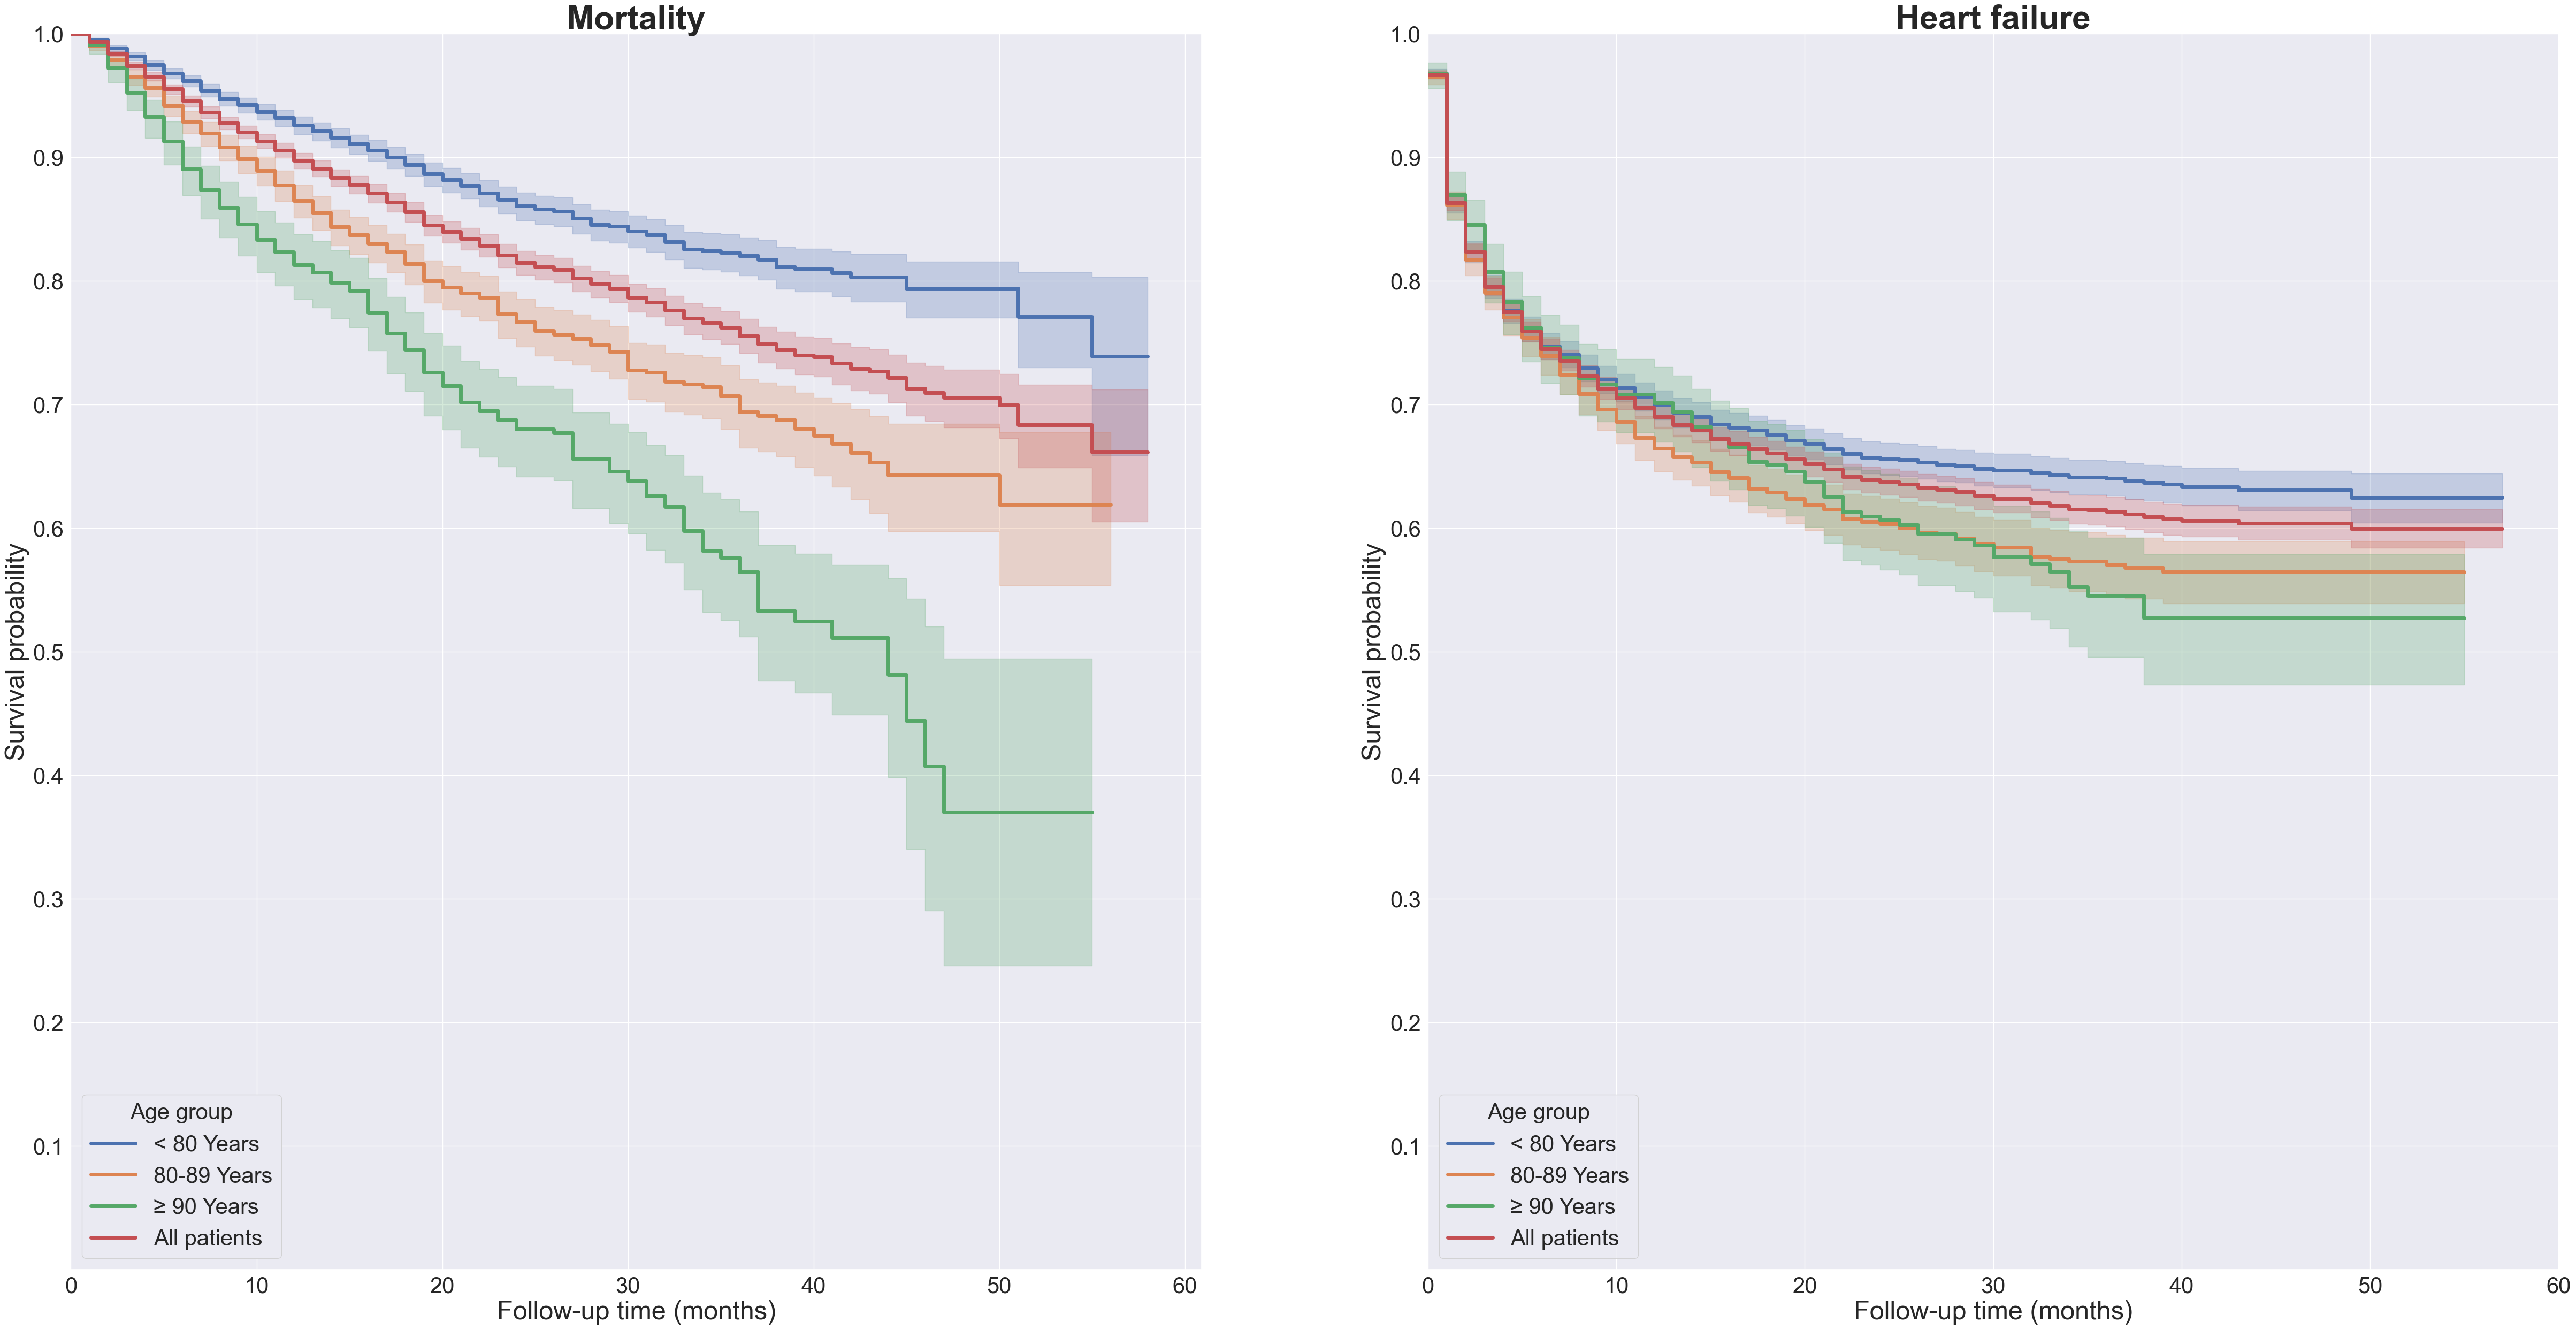

In [38]:
# Set up the seaborn style
sns.set(style="darkgrid")

# Create the Kaplan-Meier fitter object
kmf = KaplanMeierFitter()

# Create a mapping for AGEG categories and apply it to a copy of the data
ageg_mapping = {1: "< 80 Years", 2: "80-89 Years", 3: "≥ 90 Years"}
pathospit2 = pathospit.copy()
pathospit2['AGEG'] = pathospit['AGEG'].map(ageg_mapping)

# Set the time and event columns
T_values = [pathospit2['DUREE_SUIVI'], pathospit2['DUREE_AV_HOSPI']]
E_values = [pathospit2['DECES'], pathospit2['IC']]
plot_titles = ['Mortality', 'Heart failure']

# Define a writer object for Excel file
writer = pd.ExcelWriter('Death_survival_prob.xlsx')

# Create a figure and axis object
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 30))

# Specify the correct order of age categories
age_categories = ["< 80 Years", "80-89 Years", "≥ 90 Years"]

# Loop through the outcomes to create two subplots
for i, ax in enumerate(axes):
    T = T_values[i]
    E = E_values[i]
    
    # Create a DataFrame to store survival probabilities
    survival_df = pd.DataFrame()

    for age_category in age_categories:
        ageg_patients = pathospit2[pathospit2['AGEG'] == age_category]
        kmf.fit(T[ageg_patients.index], event_observed=E[ageg_patients.index], label=f"{age_category}")
        kmf.plot(ax=ax, linewidth=5)
        
        # Extract survival probabilities and add them to the DataFrame
        survival_df[age_category] = kmf.survival_function_.squeeze()

    # Fit and plot the KM curve for all patients
    kmf.fit(T, event_observed=E, label="All patients")
    kmf.plot(ax=ax, linewidth=5)

    # Add "All patients" column to the DataFrame
    survival_df["All patients"] = kmf.survival_function_.squeeze()

    # Save the survival probabilities to Excel
    survival_df.to_excel(writer, sheet_name=plot_titles[i])

    # Format the x-axis and y-axis tick labels
    ax.set_xticks(range(0, 70, 10))
    ax.set_xticklabels([str(i) for i in range(0, 70, 10)], fontsize=30)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=30)

    # Add axis labels
    ax.set_xlabel('Follow-up time (months)', fontsize=35)
    ax.set_ylabel('Survival probability', fontsize=35)

    # Set the limits for the x-axis and y-axis
    ax.set_xlim(0, None)
    ax.set_ylim(0, 1)

    # Add a legend with a title
    ax.legend(title="Age group", title_fontsize='30', fontsize=30, loc='lower left')

    # Add plot title with bold font and size 45
    ax.set_title(plot_titles[i], fontsize=45, fontweight='bold')

# Close the writer object
writer.save()

# Save the plot
plt.savefig('death_hf_age.tiff')

## KM for Mortality and HF by Litt

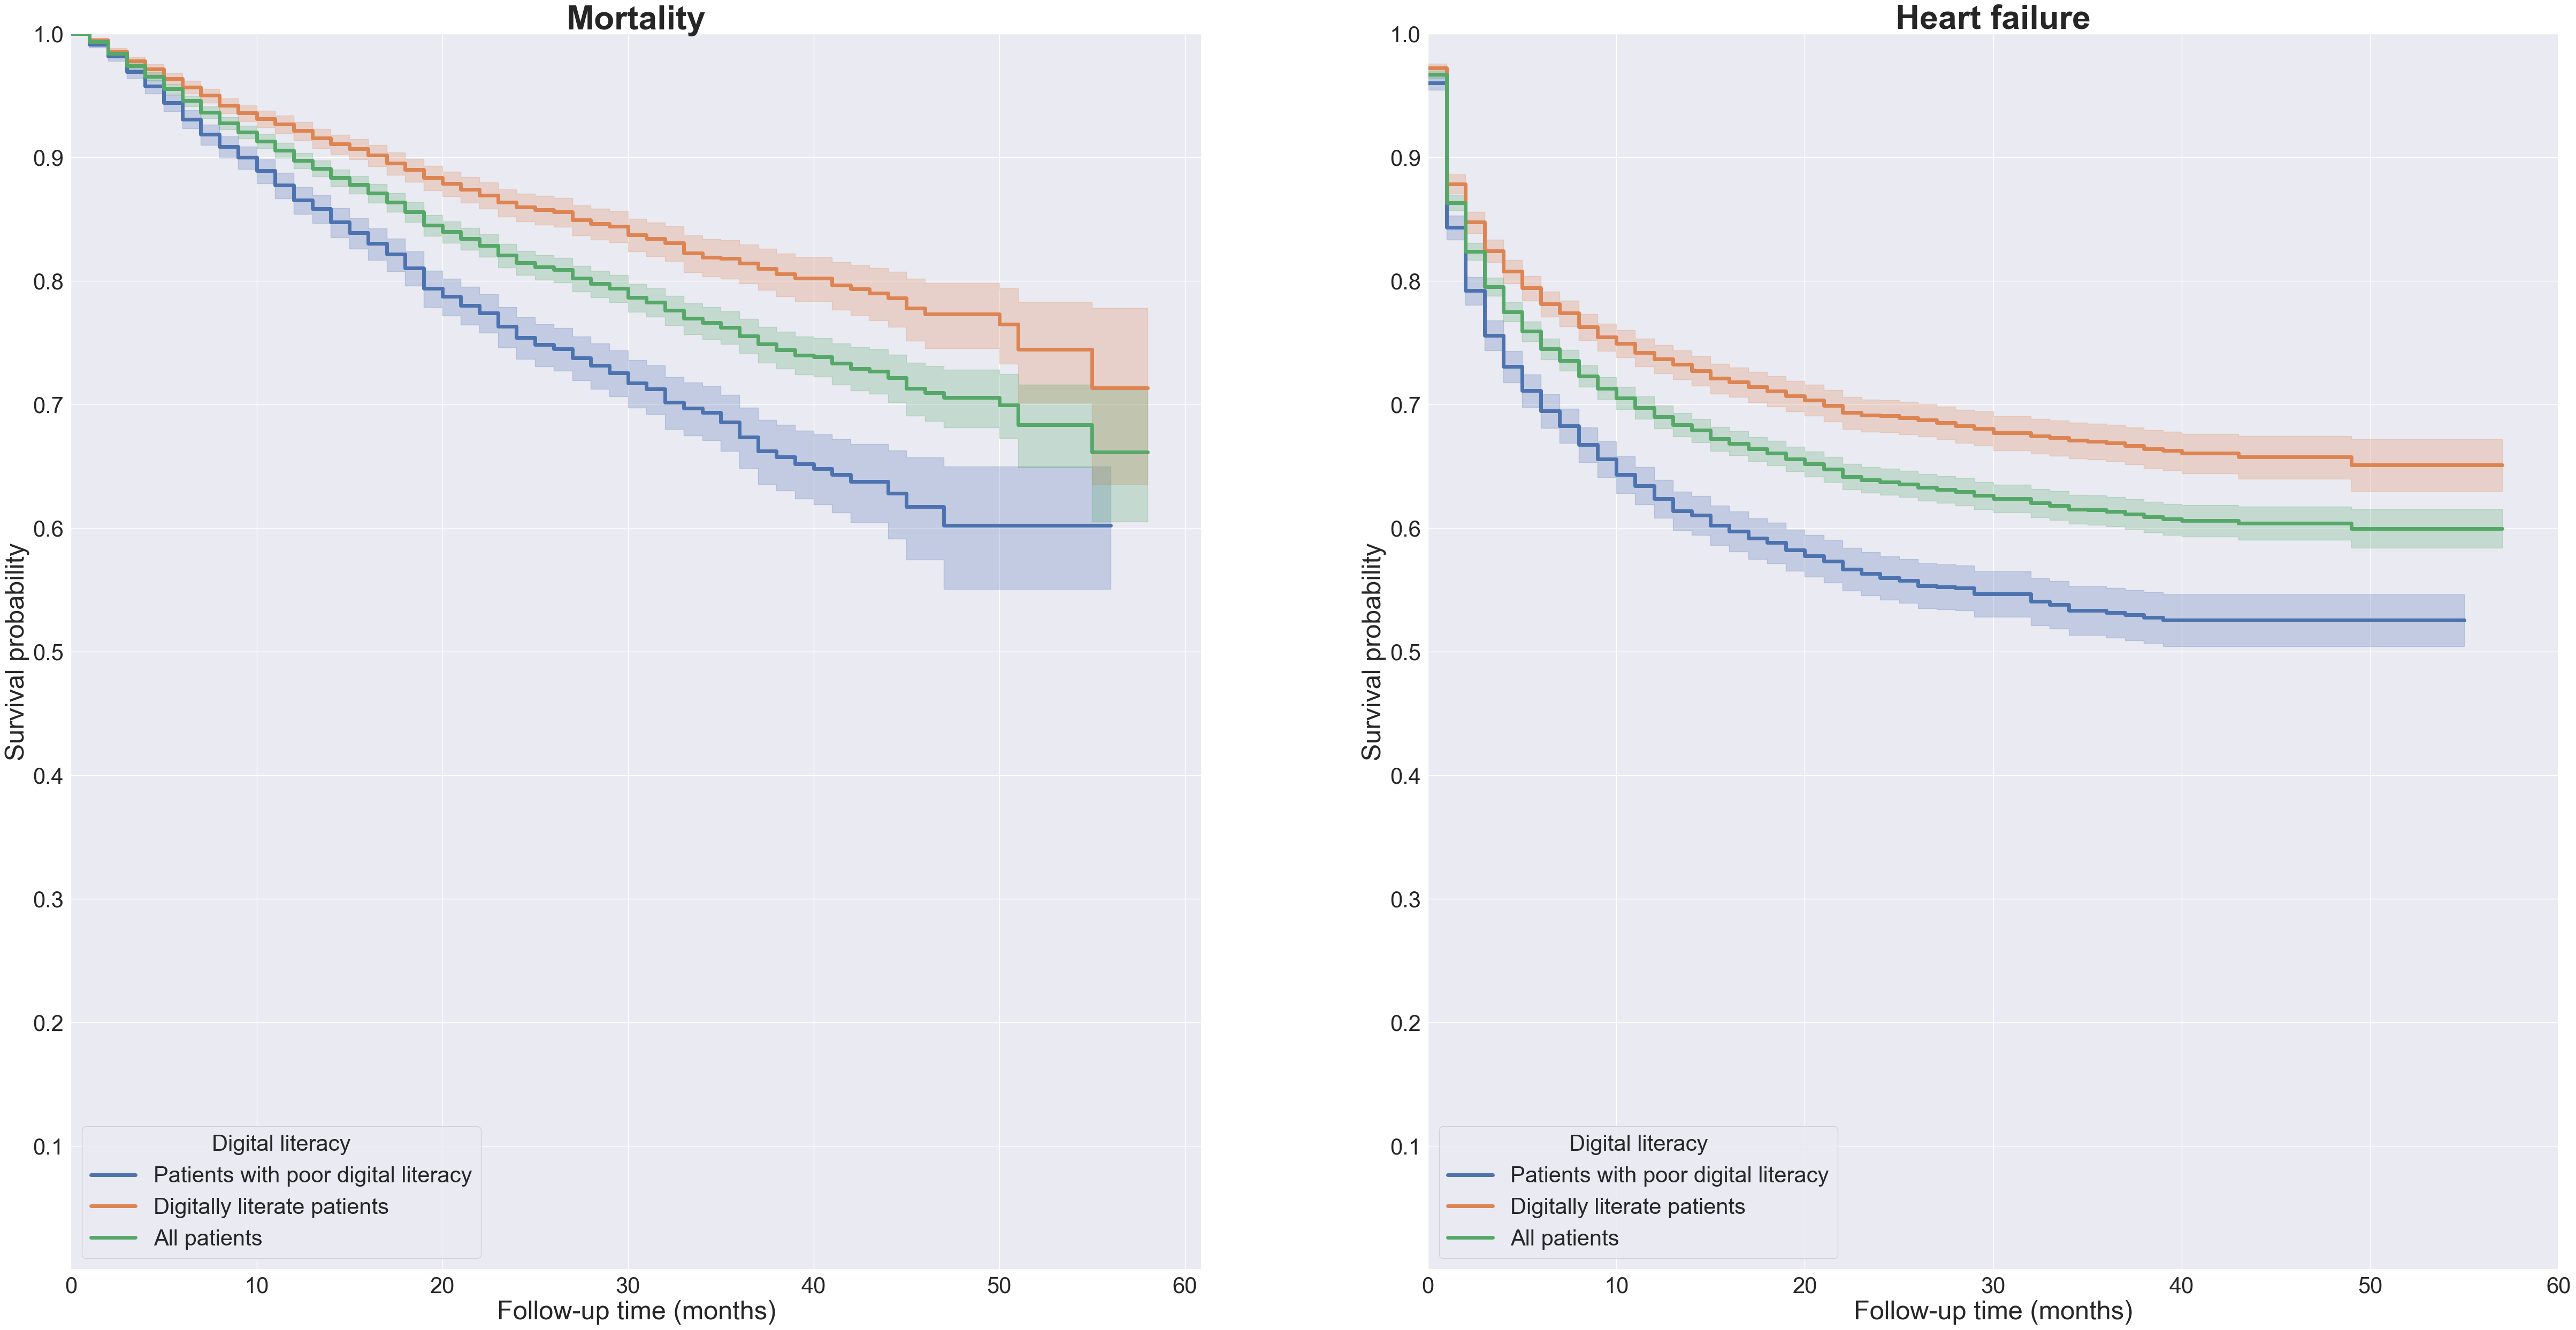

In [39]:
# Set up the seaborn style
sns.set(style="darkgrid")

# Create the Kaplan-Meier fitter object
kmf = KaplanMeierFitter()

# Create a mapping for literacy categories and apply it to a copy of the data
lit_mapping = {0: "Patients with poor digital literacy", 1: "Digitally literate patients"}
pathospit2 = pathospit.copy()
pathospit2['LITERATIEX'] = pathospit['LITERATIEX'].map(lit_mapping)

# Set the time and event columns
T_values = [pathospit2['DUREE_SUIVI'], pathospit2['DUREE_AV_HOSPI']]
E_values = [pathospit2['DECES'], pathospit2['IC']]
plot_titles = ['Mortality', 'Heart failure']

# Create a figure and axis object
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 30))

# Define a writer object for Excel file
writer = pd.ExcelWriter('HF_survival_prob.xlsx')

# Loop through the outcomes to create two subplots
for i, ax in enumerate(axes):
    T = T_values[i]
    E = E_values[i]

    # Create a DataFrame to store survival probabilities
    survival_df = pd.DataFrame()

    # Loop through the digital literacy categories and plot the KM curve for each one
    for lit_category in pathospit2['LITERATIEX'].unique():
        lit_patients = pathospit2[pathospit2['LITERATIEX'] == lit_category]
        kmf.fit(T[lit_patients.index], event_observed=E[lit_patients.index], label=f"{lit_category}")
        kmf.plot(ax=ax, linewidth=5)

        # Extract survival probabilities and add them to the DataFrame
        survival_df[lit_category] = kmf.survival_function_.squeeze()

    # Fit and plot the KM curve for all patients
    kmf.fit(T, event_observed=E, label="All patients")
    kmf.plot(ax=ax, linewidth=5)

    # Add "All patients" column to the DataFrame
    survival_df["All patients"] = kmf.survival_function_.squeeze()

    # Save the survival probabilities to Excel
    survival_df.to_excel(writer, sheet_name=plot_titles[i])

    # Format the x-axis and y-axis tick labels
    ax.set_xticks(range(0, 70, 10))
    ax.set_xticklabels([str(i) for i in range(0, 70, 10)], fontsize=30)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=30)

    # Add axis labels
    ax.set_xlabel('Follow-up time (months)', fontsize=35)
    ax.set_ylabel('Survival probability', fontsize=35)

    # Set the limits for the x-axis and y-axis
    ax.set_xlim(0, None)
    ax.set_ylim(0, 1)

    # Add a legend with a title
    ax.legend(title="Digital literacy", title_fontsize='30', fontsize=30, loc='lower left')

    # Add plot title with bold font and size 45
    ax.set_title(plot_titles[i], fontsize=45, fontweight='bold')

# Close the writer object
writer.save()

# Save the plot
plt.savefig('death_hf_lit.tiff')

## Logranktest for Mortality and HF by Age

In [40]:
ageg_mapping = {1: '< 80 Years', 2: '80-89 Years', 3: '≥ 90 Years'}
pathospit2 = pathospit.copy()
pathospit2['AGEG'] = pathospit['AGEG'].map(ageg_mapping)

T_values = [pathospit2['DUREE_SUIVI'], pathospit2['DUREE_AV_HOSPI']]
E_values = [pathospit2['DECES'], pathospit2['IC']]
plot_titles = ['Mortality', 'Heart failure']
age_categories = ['< 80 Years', '80-89 Years', '≥ 90 Years']

for i in range(2):
    T = T_values[i]
    E = E_values[i]
    
    print(f'Logrank Test Results for {plot_titles[i]}:')
    
    for j, age_category1 in enumerate(age_categories):
        for age_category2 in age_categories[j+1:]:
            
            group1 = pathospit2[pathospit2['AGEG'] == age_category1]
            group2 = pathospit2[pathospit2['AGEG'] == age_category2]
            
            results = logrank_test(T[group1.index], T[group2.index], 
                                   event_observed_A=E[group1.index], 
                                   event_observed_B=E[group2.index])
            print(f'Logrank Test Comparing {age_category1} vs {age_category2}: p-value = {results.p_value:.5f}')
            print(results.print_summary())

Logrank Test Results for Mortality:
Logrank Test Comparing < 80 Years vs 80-89 Years: p-value = 0.00000


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         114.96 <0.005     86.69

None
Logrank Test Comparing < 80 Years vs ≥ 90 Years: p-value = 0.00000


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         217.49 <0.005    161.10

None
Logrank Test Comparing 80-89 Years vs ≥ 90 Years: p-value = 0.00000


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          31.98 <0.005     25.94

None
Logrank Test Results for Heart failure:
Logrank Test Comparing < 80 Years vs 80-89 Years: p-value = 0.00076


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.33 <0.005     10.36

None
Logrank Test Comparing < 80 Years vs ≥ 90 Years: p-value = 0.14259


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.15 0.14      2.81

None
Logrank Test Comparing 80-89 Years vs ≥ 90 Years: p-value = 0.51330


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.43 0.51      0.96

None


## Logranktest for Mortality and HF by Litt

In [41]:
lit_mapping = {0: "Poor digitally literate", 1: "Digitally literate"}
pathospit2 = pathospit.copy()
pathospit2['LITERATIEX'] = pathospit['LITERATIEX'].map(lit_mapping)

T_values = [pathospit2['DUREE_SUIVI'], pathospit2['DUREE_AV_HOSPI']]
E_values = [pathospit2['DECES'], pathospit2['IC']]
plot_titles = ['Mortality', 'Heart failure']

for i in range(2):
    T = T_values[i]
    E = E_values[i]
    
    # Get data for each literacy category
    lit_illiterate = pathospit2[pathospit2['LITERATIEX'] == "Poor digitally literate"]
    lit_literate = pathospit2[pathospit2['LITERATIEX'] == "Digitally literate"]
    
    # Perform the logrank test and print the results
    results = logrank_test(T[lit_illiterate.index], T[lit_literate.index], 
                           event_observed_A=E[lit_illiterate.index], 
                           event_observed_B=E[lit_literate.index])
    print(f'Logrank Test Results for {plot_titles[i]}: p-value = {results.p_value:.5f}')
    print(results.print_summary())

Logrank Test Results for Mortality: p-value = 0.00000


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         133.32 <0.005    100.03

None
Logrank Test Results for Heart failure: p-value = 0.00000


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         150.93 <0.005    112.82

None
